# NLP 2-AIML Capstone Grp 8

# Overview


##Project Detail

In this dataset, the information about accidents in 12 manufacturing plants in 3 countries are given by a brazilian company, IHM Stefanini. 

Dataset columns are below:

Date : timestamp or time/date information
Countries : which country the accident occurred (anonymized)
Local : the city where the manufacturing plant is located (anonymized)
Industry sector : which sector the plant belongs to
Accident level : from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
Potential Accident Level : Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
Genre : if the person is male of female
Employee or Third Party : if the injured person is an employee or a third party
Critical Risk : some description of the risk involved in the accident
Description : Detailed description of how the accident happened

##Goal of this notebook
Performing EDA technique
Performing Pre-processing technique
Feature Extraction: LSA & LDA
Re-classifying Risk Categories
Loading actual data to prepare our final dataset
Preprocessing Pipeline Code

#Import libraries

In [ ]:
!pip install pyldavis
!pip install -U pandas-profiling

     |████████████████████████████████| 1.6MB 4.2MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=55f2c7682d306c44831205a4d4fcd6c68ce6c8079648e0072ae5fc42bfbead15
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis
     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 604kB 16.5MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 3.1MB 17.4MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 296kB 34.9MB/s 
  Created wheel for phik: filename=phik-0.11.0-cp36-none-any.whl size=599738 sha256=32088d487403b511712754bfa32895c3ea9d91d06ec612f8aced2b2bda216191
  Stored in directory: /root/.cache/pip/wheels/af/54/11/aba77f21075918de02f7964eabfe8c10d5542df9e6ad10b225
  Created w

# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the current working directory
'''
import os; 
os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')
'''
import os; os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [3]:
import pandas as pd
#ram path 
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv")
#satya path /content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv
#df = pd.read_csv("/content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")
#df = pd.read_csv("industrial_safety_and_health_database_with_accidents_description.csv")
df.head(3)

Unnamed: 0  ...                                        Description
0           0  ...  While removing the drill rod of the Jumbo 08 f...
1           1  ...  During the activation of a sodium sulphide pum...
2           2  ...  In the sub-station MILPO located at level +170...

[3 rows x 11 columns]

Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem,punkt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import lightgbm as lgb
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')


Output hidden; open in https://colab.research.google.com to view.

# Performing Exploratory Data Analysis on the data
EDA helps in better data understanding. EDA is known for capturing and analyzing uncommon data patterns that will be skipped by typical machine learning algorithms.

## Understanding the columns.
A column represents a category of information, such as an opportunity source or account name or feature


### Non-null counts and the Data type of each column

In [ ]:
df.info()
#The data has 425 accident records, 10 columns, 9 object type and 1 integer type 
#All the columns show a non-null count of 425 indicating no null/missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


In [ ]:
df.isnull().sum()

Unnamed: 0                  0
Data                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Genre                       0
Employee or Third Party     0
Critical Risk               0
Description                 0
dtype: int64

### Checking for Duplicates in our data and dropping them

In [ ]:
##Identify duplicates records in the data 
#Removing the Index column and the Critical risk column to check the duplicates
df1=df.drop('Unnamed: 0',axis=1)
df1.head(1)
#df1=df1.drop('Critical Risk',axis=1)
dupes = df1.duplicated()
sum(dupes)

7

In [ ]:
##here we can see that there are 8 duplicated rows. We want to remove the duplicate rows.

#Removing Duplicates
df =df1.drop_duplicates()

In [ ]:
df.info()
#  Now we  have 418 records after removal of the 7 records from initial 425
# we have now removed the index column as well as it is not conveying any information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Data                      418 non-null    object
 1   Countries                 418 non-null    object
 2   Local                     418 non-null    object
 3   Industry Sector           418 non-null    object
 4   Accident Level            418 non-null    object
 5   Potential Accident Level  418 non-null    object
 6   Genre                     418 non-null    object
 7   Employee or Third Party   418 non-null    object
 8   Critical Risk             418 non-null    object
 9   Description               418 non-null    object
dtypes: object(10)
memory usage: 35.9+ KB


### Check for duplicates exluding Critcal Risk and Industry Sector

In [ ]:
df1=df1.drop('Critical Risk',axis=1)
df1=df1.drop('Industry Sector',axis=1)
dupes = df1.duplicated()
sum(dupes)

8

## Date column Transformation

### Transform Date to Day,Month, Year and Weekday and WeekofYear
Accidents may increase or decrease throughout the year or month, so We added date & time features such as year,month and day.

In [ ]:
df['Data'] = pd.to_datetime(df['Data'])
df['Year'] = df['Data'].apply(lambda x : x.year)
df['Month'] = df['Data'].apply(lambda x : x.month)
df['Day'] = df['Data'].apply(lambda x : x.day)
df['Weekday'] = df['Data'].apply(lambda x : x.day_name())
df['WeekofYear'] = df['Data'].apply(lambda x : x.weekofyear)
df.head(3)

Data   Countries     Local  ... Day    Weekday WeekofYear
0 2016-01-01  Country_01  Local_01  ...   1     Friday         53
1 2016-01-02  Country_02  Local_02  ...   2   Saturday         53
2 2016-01-06  Country_01  Local_03  ...   6  Wednesday          1

[3 rows x 15 columns]

### Extract Seasons

Accordin to this discussion, countries where the dataset was collected is anonymized but they are all located in South America. So in this analysis, let's assume the dataset was collected in Brazil.

It is said in this web page that Brazil has four climatological seasons as below.

Spring : September to November
Summer : December to February
Autumn : March to May
Winter : June to August
We can create seasonal variable based on month variable.

In [ ]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

In [ ]:
df['Season'] = df['Month'].apply(month2seasons)
df.head(3)

Data   Countries     Local  ...    Weekday WeekofYear  Season
0 2016-01-01  Country_01  Local_01  ...     Friday         53  Summer
1 2016-01-02  Country_02  Local_02  ...   Saturday         53  Summer
2 2016-01-06  Country_01  Local_03  ...  Wednesday          1  Summer

[3 rows x 16 columns]

## Description - NLP Pre-processing
Description column contains the details of why accidents happend. So we tried to add new features by using this important information with NLP technique.

In addition to the predifined stopwords in WORDCLOUD, We have defined handmade-stopwords list by inspecting the documents in 'Description' column.

### Stop Words and text clean-up

In [ ]:
STOPWORDS.update(["cm", "kg", "mr", "wa" ,"nv", "ore", "da", "pm", "am", "cx"])
print(STOPWORDS)

{'cx', 'did', 'has', 'being', 'wa', "i'll", 'ours', 'that', 'themselves', 'before', "let's", 'who', "we'd", "that's", 'ever', 'out', 'off', 'were', 'until', 'too', 'but', 'other', "i'd", 'no', "we're", 'under', 'here', "i'm", 'where', "doesn't", 'like', 'are', 'at', 'these', "she's", 'to', 'me', "what's", 'it', 'while', "when's", 'very', "she'll", 'few', "weren't", 'nv', "we've", 'down', 'itself', 'r', 'would', 'should', 'this', 'kg', 'between', 'his', "haven't", 'on', 'whom', 'up', 'can', 'in', 'any', "hadn't", 'more', 'com', 'the', 'what', 'a', "you've", 'herself', "i've", 'an', 'da', 'k', "didn't", 'both', "they've", 'him', 'cannot', 'do', 'if', 'he', 'some', 'we', "couldn't", 'which', "where's", 'above', 'than', 'you', "mustn't", 'yours', 'am', 'so', 'http', "aren't", "wouldn't", 'as', 'just', 'is', 'nor', "shan't", 'because', "you'd", 'your', "can't", 'during', 'over', 'could', 'otherwise', 'those', 'mr', 'them', 'hers', 'about', 'however', 'not', 'once', 'there', 'was', 'get', "w

NLP preprocessing pipeline is a little complicated, so We made preprocessing function

In [ ]:
import re
def nlp_preprocesser(row):
    sentence = row.Description
    #retaining only the alphabets in the text
    #print ("here1")
    sentence=re.sub('[^a-zA-z\s]','',sentence)
    #convert all characters to lowercase
    lowered = sentence.lower()
    #print ("here2")
    tok = tokenize.word_tokenize(lowered)
    print ("tok.type",type(tok))
    print(tok)
    #vocabSize = 2000
    #tokenizer = Tokenizer(num_words=vocabSize, split=' ')
    #tok1=tokenizer.fit_on_texts(sentence)
    #tok2 = tokenizer.texts_to_sequences(sentence)
    #print ("tok2.type",type(tok2))
    #print (tok2)
    #print ("tok1.type",type(tok1))
    #print (tok1)
    #lemmatizing & stemming
    #for i in tok:
        #print("****:", i)
    lemmatizer = stem.WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(i) for i in tok if i not in STOPWORDS]
    #stemmer = stem.PorterStemmer()
    #stems = [stemmer.stem(i) for i in lem if i not in STOPWORDS]
    #print (lem)
    #remove non-alphabetical characters like '(', '.' or '!'
    #alphas = [i for i in sentence if i.isalpha() and (i not in STOPWORDS)]
    #print(alphas)
    return " ".join(lem)

In [ ]:
df['Description_processed'] = df.apply(nlp_preprocesser, axis=1)

tok.type <class 'list'>
['while', 'removing', 'the', 'drill', 'rod', 'of', 'the', 'jumbo', 'for', 'maintenance', 'the', 'supervisor', 'proceeds', 'to', 'loosen', 'the', 'support', 'of', 'the', 'intermediate', 'centralizer', 'to', 'facilitate', 'the', 'removal', 'seeing', 'this', 'the', 'mechanic', 'supports', 'one', 'end', 'on', 'the', 'drill', 'of', 'the', 'equipment', 'to', 'pull', 'with', 'both', 'hands', 'the', 'bar', 'and', 'accelerate', 'the', 'removal', 'from', 'this', 'at', 'this', 'moment', 'the', 'bar', 'slides', 'from', 'its', 'point', 'of', 'support', 'and', 'tightens', 'the', 'fingers', 'of', 'the', 'mechanic', 'between', 'the', 'drilling', 'bar', 'and', 'the', 'beam', 'of', 'the', 'jumbo']
tok.type <class 'list'>
['during', 'the', 'activation', 'of', 'a', 'sodium', 'sulphide', 'pump', 'the', 'piping', 'was', 'uncoupled', 'and', 'the', 'sulfide', 'solution', 'was', 'designed', 'in', 'the', 'area', 'to', 'reach', 'the', 'maid', 'immediately', 'she', 'made', 'use', 'of', 'th

##N-grams
N-grams are a tool in nlp for finding sets of commonly co-occuring words, where n refers to the number of consecutive occuring words. for instance 'near', 'drainage', 'pump' would be a 3 word n-gram or trigram.

In [ ]:
def ngram_func(ngram, trg='', trg_value=''):
    #trg_value is list-object
    if (trg == '') or (trg_value == ''):
        string_filterd =  df['Description_processed'].sum().split()
    else:
        string_filterd =  df[df[trg].isin(trg_value)]['Description_processed'].sum().split()
    dic = nltk.FreqDist(nltk.ngrams (string_filterd, ngram)).most_common(20)
    ngram_df = pd.DataFrame(dic, columns=['ngram','count'])
    ngram_df.index = [' '.join(i) for i in ngram_df.ngram]
    ngram_df.drop('ngram',axis=1, inplace=True)
    return ngram_df

In [ ]:
df['Description_processed']

0      removing drill rod jumbo maintenance superviso...
1      activation sodium sulphide pump piping uncoupl...
2      substation milpo located level collaborator ex...
3      approximately ob personnel begin task unlockin...
4      approximately circumstance mechanic anthony gr...
                             ...                        
420    approximately approximately lifting kelly hq t...
421    collaborator moved infrastructure office julio...
422    environmental monitoring activity area employe...
423    employee performed activity stripping cathode ...
424    assistant cleaned floor module e central camp ...
Name: Description_processed, Length: 418, dtype: object

### Unigram plot to identify the most frequently occuring words
The frequent words appearing in the Description includes causing, left, hand, right, operator, etc predicts it as a labor intensive work being done manually

In [ ]:
unigram=ngram_func(1)
unigram.head()
unigram['word']=unigram.index

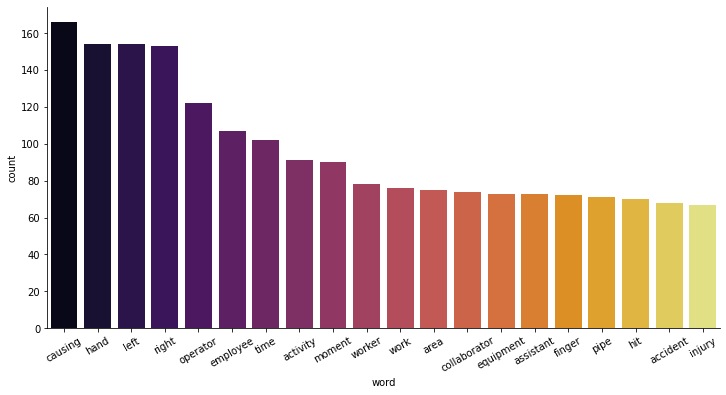

In [ ]:
g=sns.catplot(x="word", y="count" ,kind="bar", palette="inferno", data=unigram,aspect=2,)
g.set_xticklabels(rotation=30)

### Bigram plot to identify the most frequently  words occuring together
The frequency count on the bigram index shows words like left hand, time accident, right hand as the frequent adjacent elements from a string of tokens again predicts it as a labor intensive work being done manually

In [ ]:
bigram=ngram_func(2)

bigram['word']=bigram.index
bigram.head()

count            word
left hand          58       left hand
time accident      55   time accident
right hand         48      right hand
causing injury     35  causing injury
finger left        25     finger left

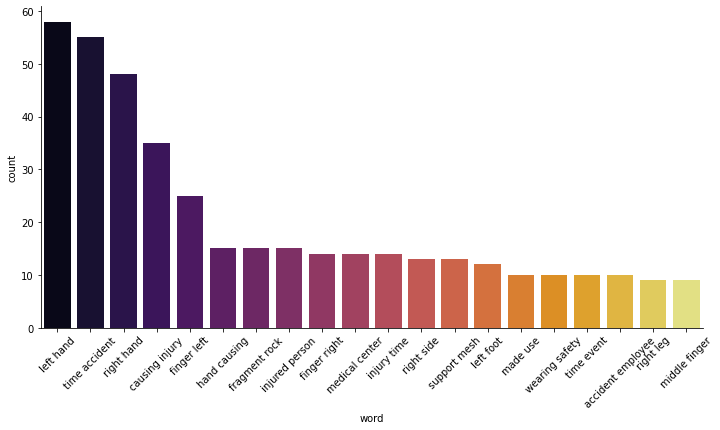

In [ ]:
g=sns.catplot(x="word", y="count" ,kind="bar" , palette="inferno", data=bigram,aspect=2)
g.set_xticklabels(rotation=45)

### Trigram plot to identify the most frequently  words occuring together

The frequency count on the trigram index shows words like finger left hand, injury time accident, finger right hand as the frequent adjacent elements from a string of tokens.

In [ ]:
trigram=ngram_func(3)

trigram['word']=trigram.index
trigram.head()

count                     word
finger left hand            19         finger left hand
injury time accident        13     injury time accident
finger right hand           11        finger right hand
time accident employee       9   time accident employee
described time accident      7  described time accident

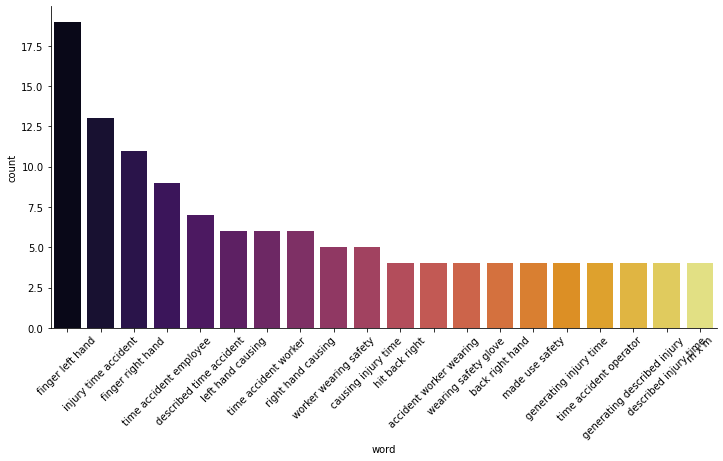

In [ ]:
g=sns.catplot(x="word", y="count" ,kind="bar" , palette="inferno", data=trigram,aspect=2)
g.set_xticklabels(rotation=45)

### Frequent words occuring based on Portential accident Levels

In [ ]:
def pot_ngram_func(ngram,pot_acc, trg='', trg_value=''):
    #trg_value is list-object
    if (trg == '') or (trg_value == ''):
        string_filterd =  df[df['Potential Accident Level'] == pot_acc]['Description_processed'].sum().split()
    else:
        string_filterd =  df[df[trg].isin(trg_value)]['Description_processed'].sum().split()
    dic = nltk.FreqDist(nltk.ngrams (string_filterd, ngram)).most_common(20)
    ngram_df = pd.DataFrame(dic, columns=['ngram','count'])
    ngram_df.index = [' '.join(i) for i in ngram_df.ngram]
    ngram_df.drop('ngram',axis=1, inplace=True)
    return ngram_df

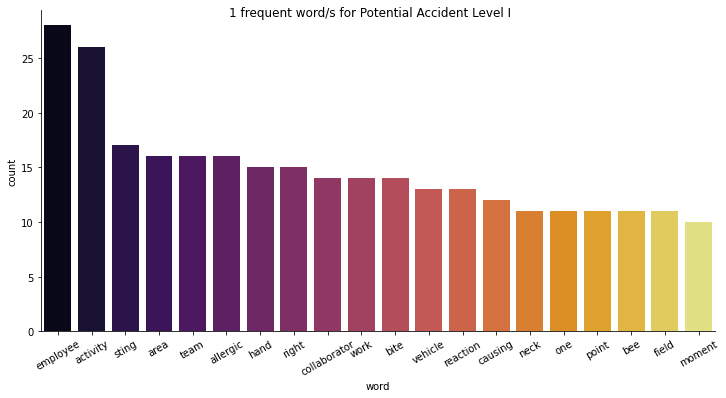

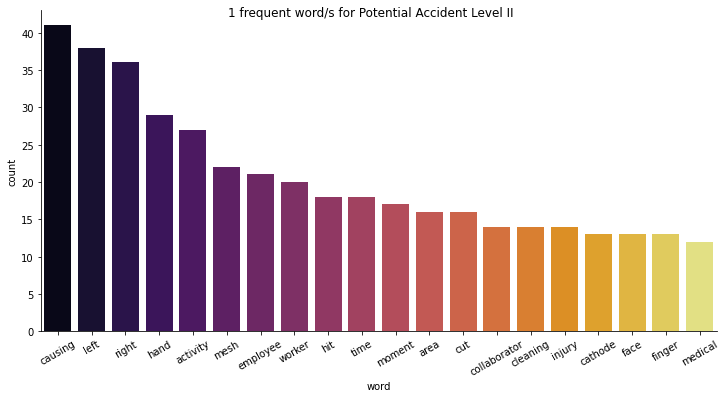

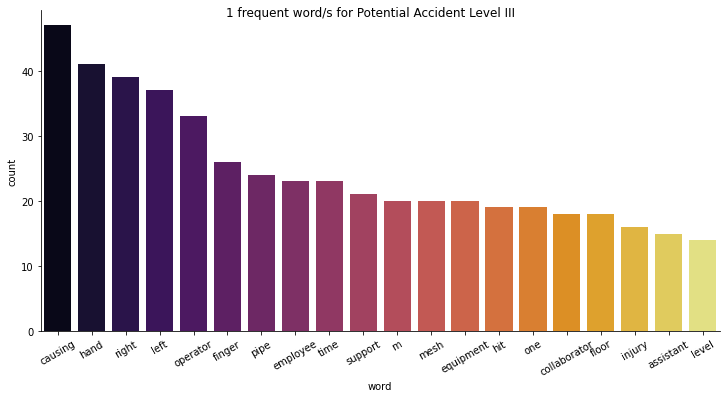

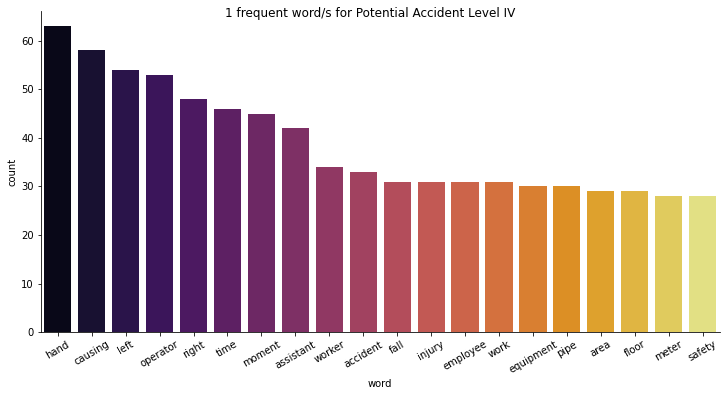

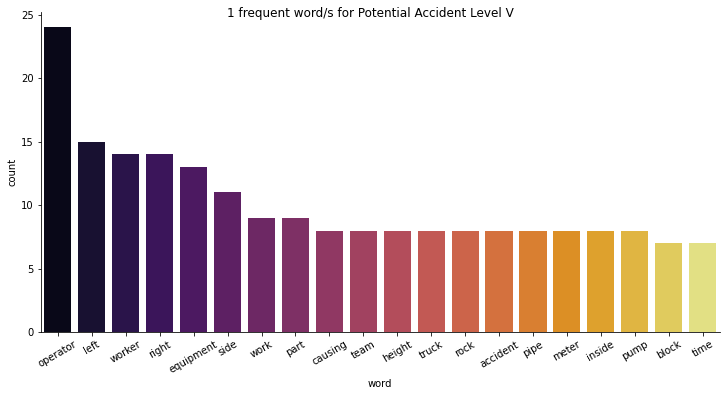

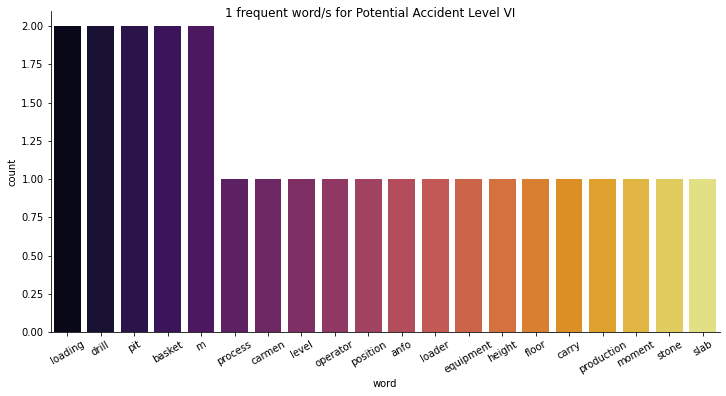

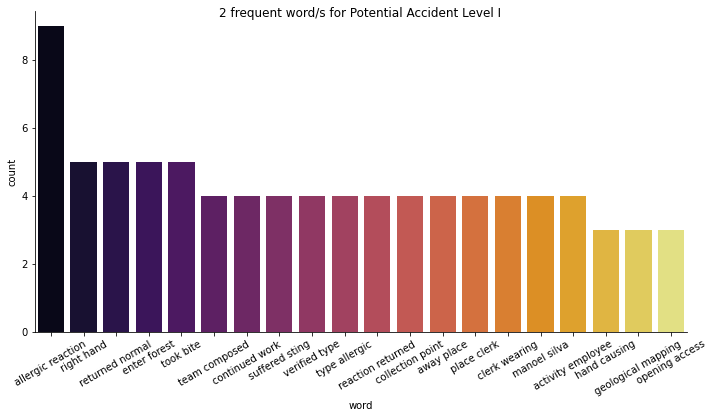

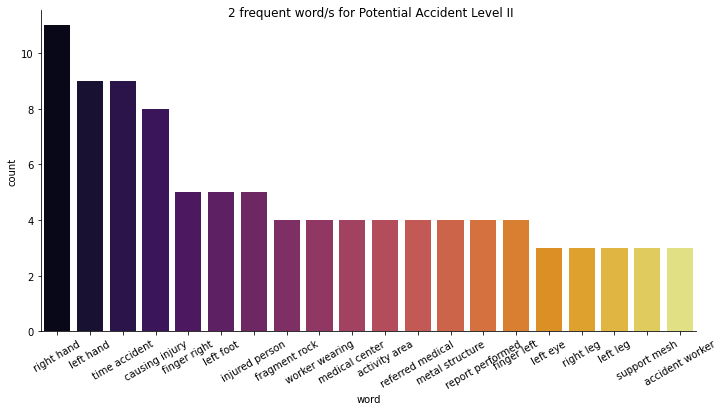

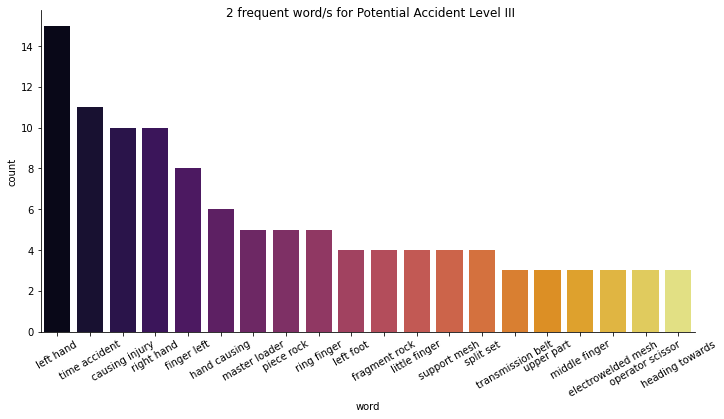

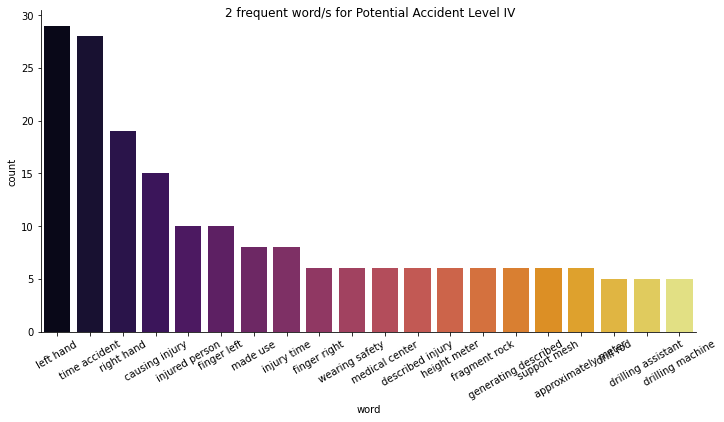

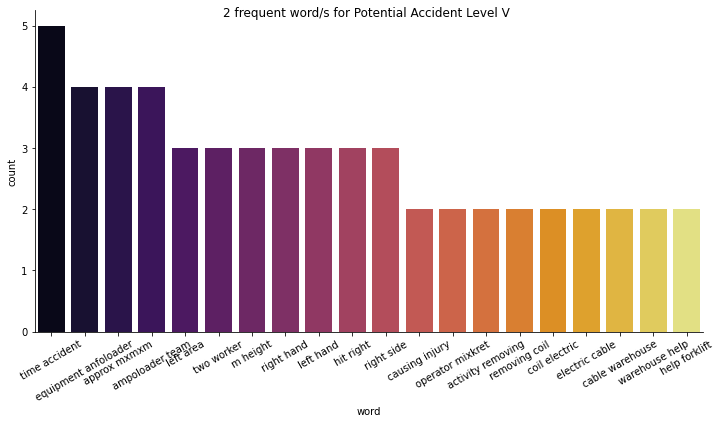

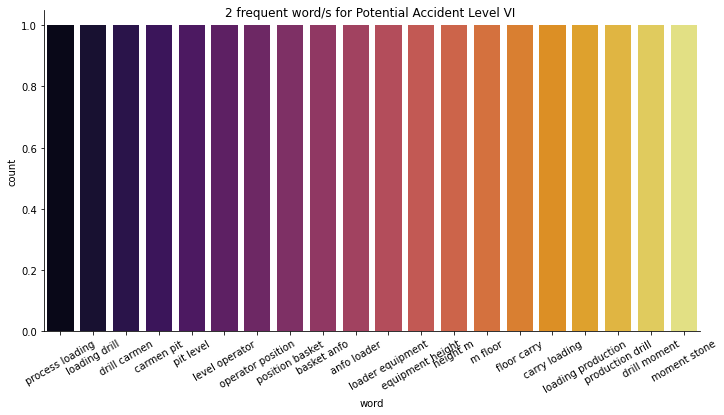

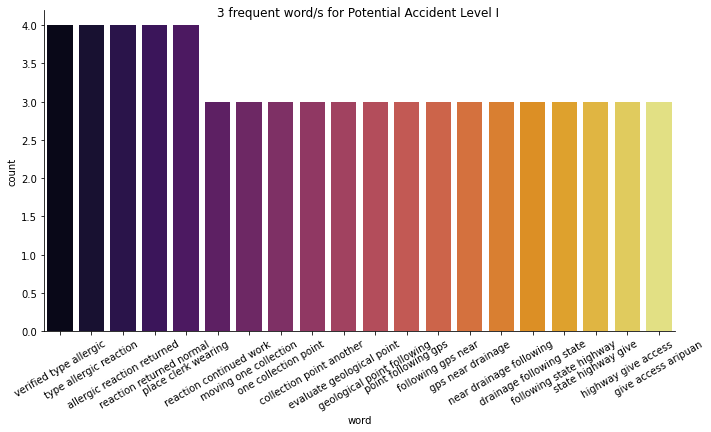

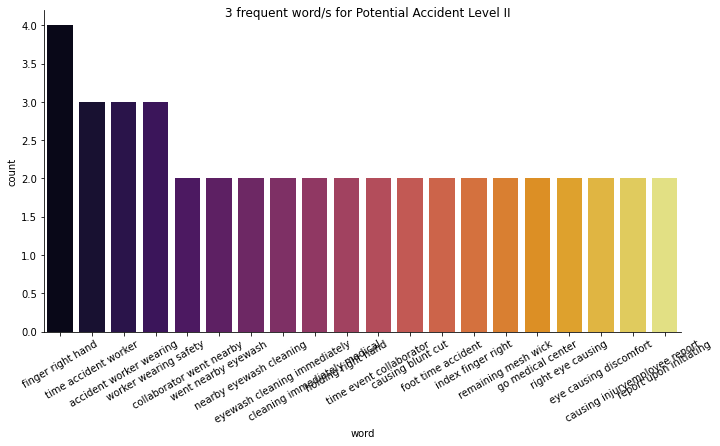

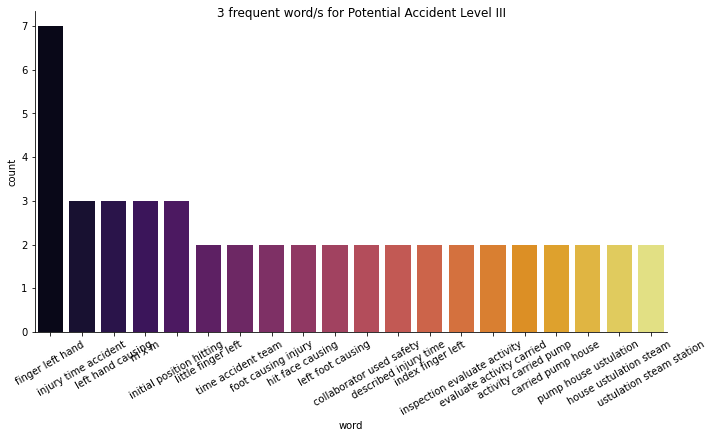

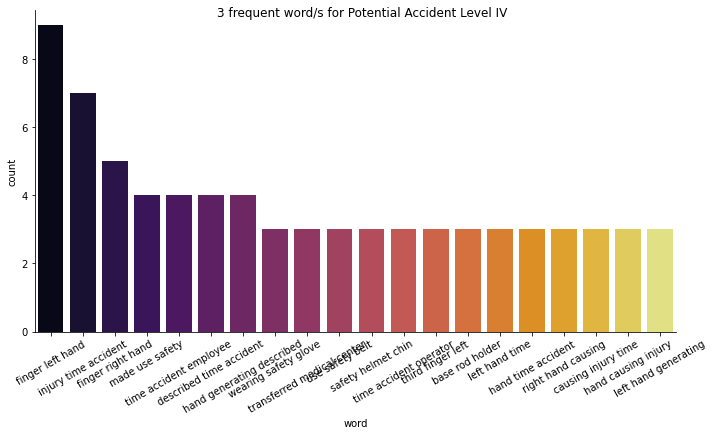

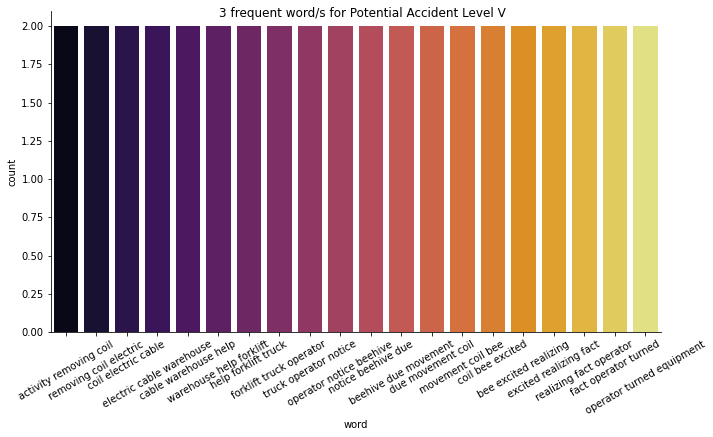

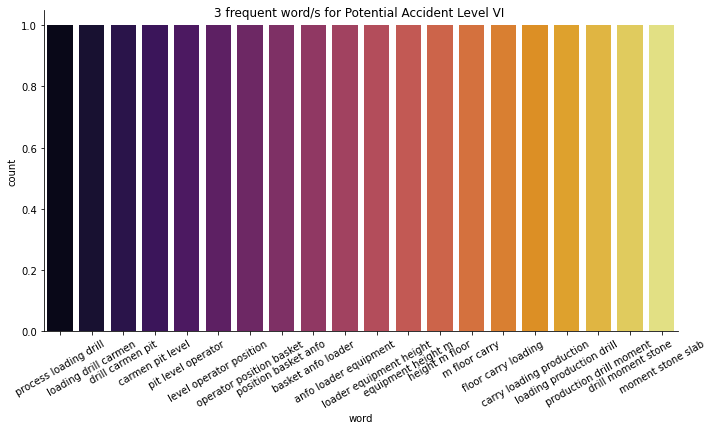

In [ ]:
for n_g in (1,2,3):
  for x in ('I','II','III','IV','V','VI'):
    n_gram=pot_ngram_func(n_g,x)
    n_gram['word']= n_gram.index
    g=sns.catplot(x="word".format(x), y="count" ,kind="bar", palette="inferno", data=n_gram,aspect=2)
    g.fig.suptitle('{} frequent word/s for Potential Accident Level {}'.format(n_g,x))
    g.set_xticklabels(rotation=30)

### Frequent words occuring based on Accident Levels

In [ ]:
def acc_ngram_func(ngram,pot_acc, trg='', trg_value=''):
    #trg_value is list-object
    if (trg == '') or (trg_value == ''):
        string_filterd =  df[df['Accident Level'] == pot_acc]['Description_processed'].sum().split()
    else:
        string_filterd =  df[df[trg].isin(trg_value)]['Description_processed'].sum().split()
    dic = nltk.FreqDist(nltk.ngrams (string_filterd, ngram)).most_common(20)
    ngram_df = pd.DataFrame(dic, columns=['ngram','count'])
    ngram_df.index = [' '.join(i) for i in ngram_df.ngram]
    ngram_df.drop('ngram',axis=1, inplace=True)
    return ngram_df

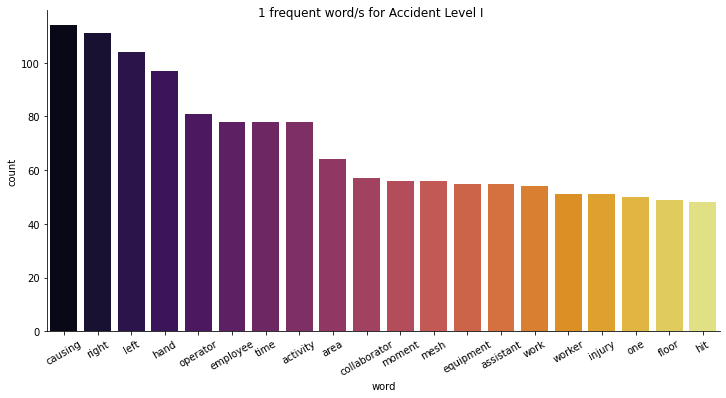

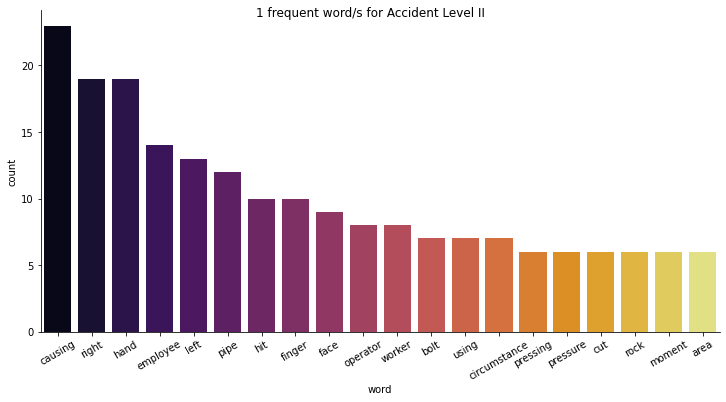

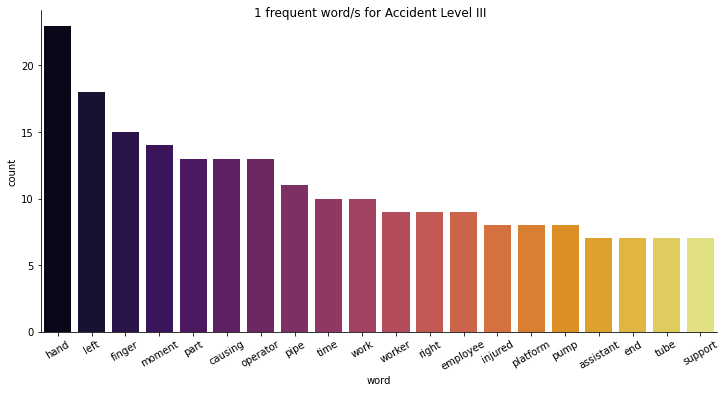

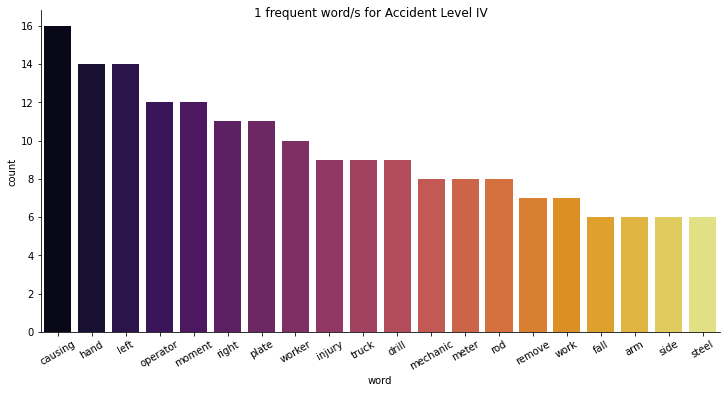

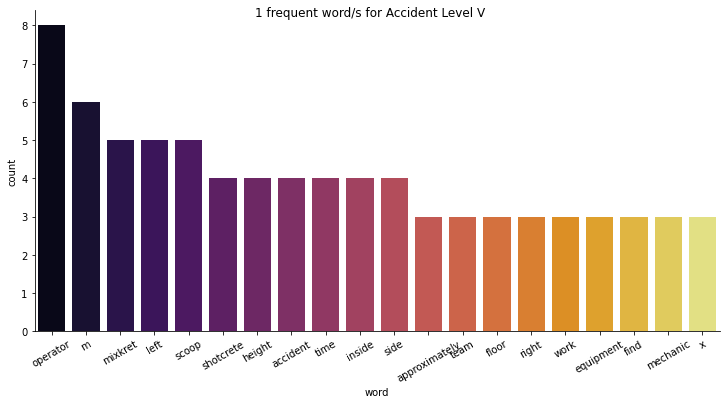

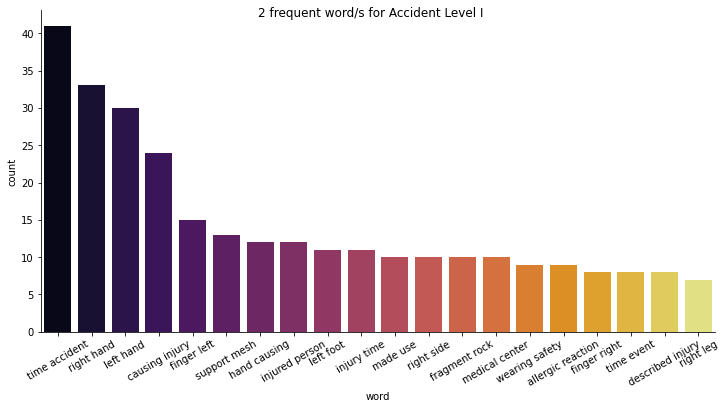

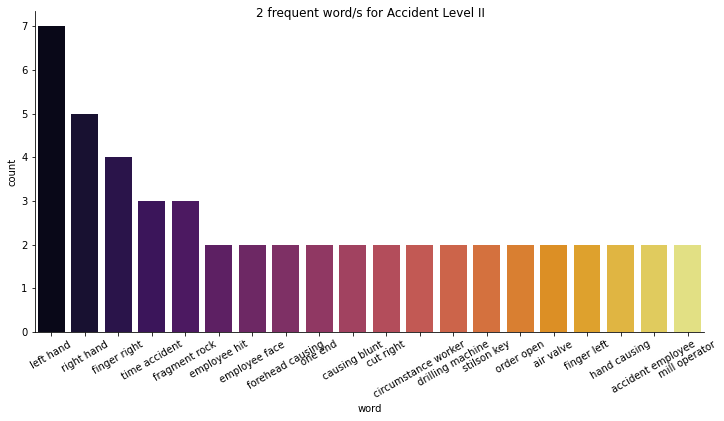

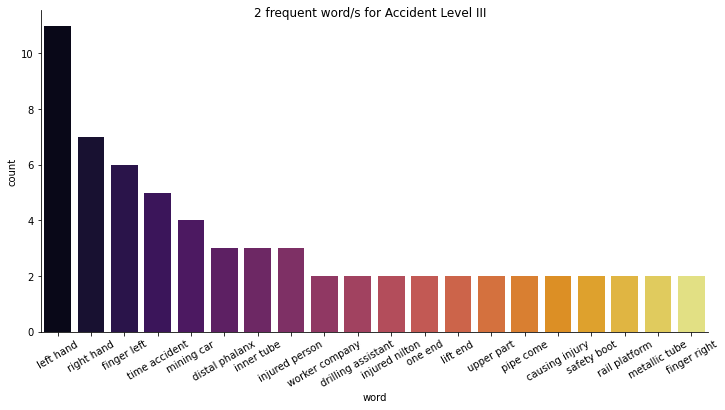

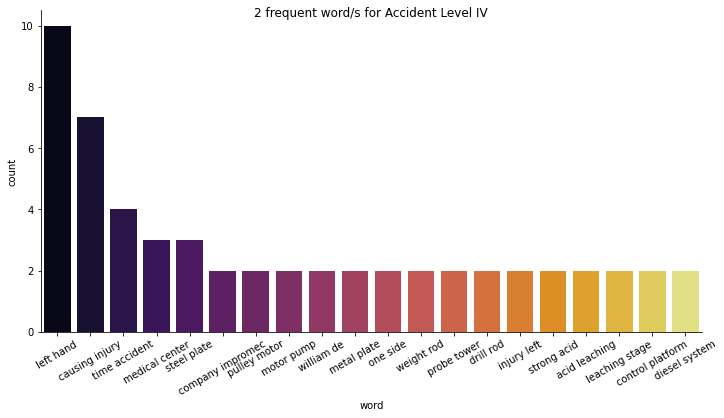

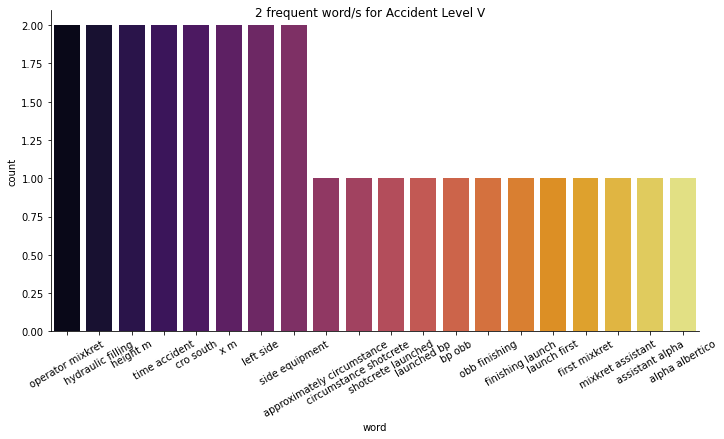

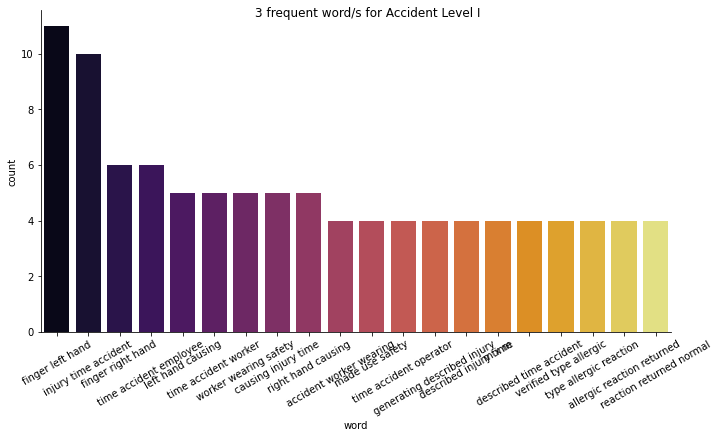

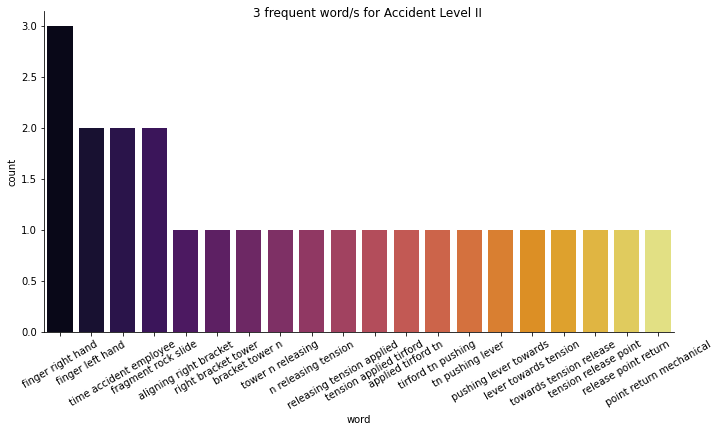

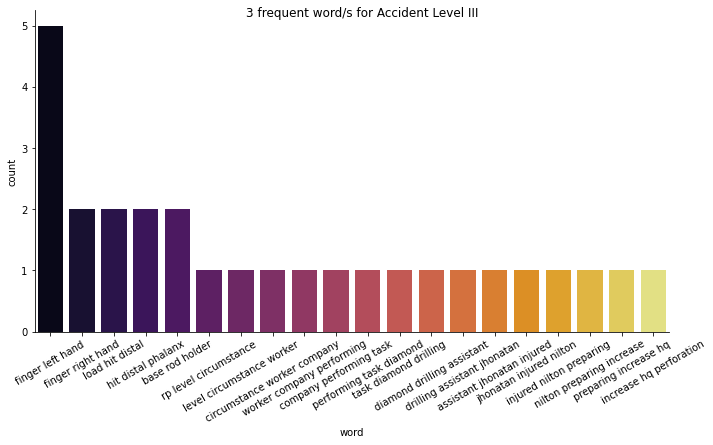

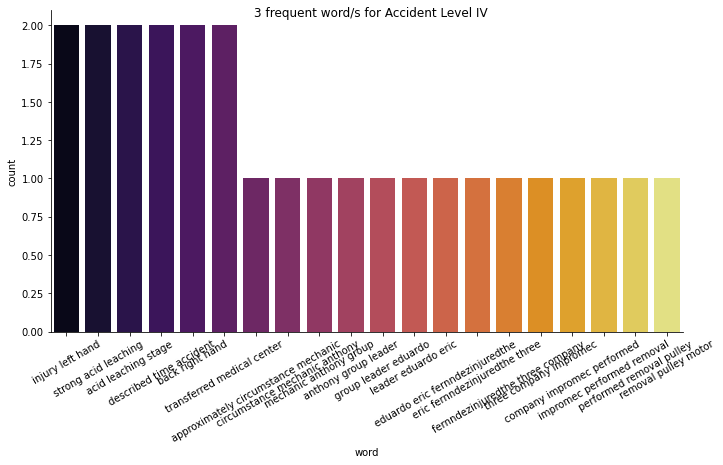

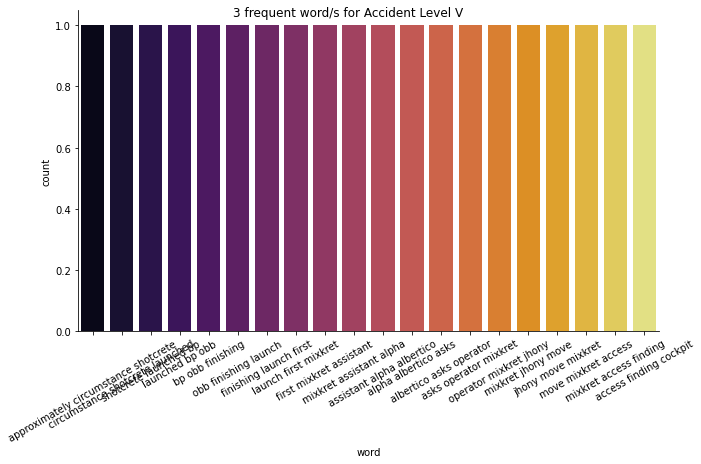

In [ ]:
for n_g in (1,2,3):
  for x in ('I','II','III','IV','V'):
    n_gram=acc_ngram_func(n_g,x)
    n_gram['word']= n_gram.index
    g=sns.catplot(x="word".format(x), y="count" ,kind="bar", palette="inferno", data=n_gram,aspect=2)
    g.fig.suptitle('{} frequent word/s for Accident Level {}'.format(n_g,x))
    g.set_xticklabels(rotation=30)

### Number of words 

In [ ]:
df['len_description'] = df['Description_processed'].apply(lambda x: len(x.split(" ")))

df.head()

Unnamed: 0  ... len_description
0           0  ...              37
1           1  ...              27
2           2  ...              28
3           3  ...              46
4           4  ...              39

[5 rows x 19 columns]

### Histogram of words

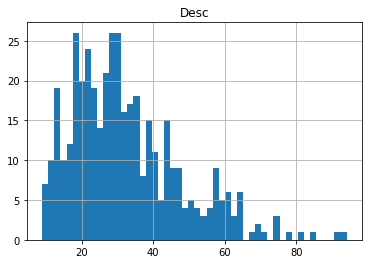

In [ ]:
import matplotlib.pyplot as plt

desc_word_count = []

# populate the lists with sentence lengths
for i in df['Description_processed']:
  desc_word_count.append(len(i.split()))


length_df = pd.DataFrame({'Desc':desc_word_count})
length_df.hist(bins = 50)
plt.show()

### Percentage of cleaned description below 60 words

In [ ]:
#Let's check the percentage of heading below 60 words
cnt=0
for i in df['Description_processed']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(round(cnt/len(df['Description_processed'])*100,2))

93.41


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
 11  Year                      425 non-null    int64         
 12  Month                 

## Univariate & Bivariate Analysis

Univariate analysis refer to the analysis of a single variable. The main purpose of univariate analysis is to summarize and find patterns in the data. The key point is that there is only one variable involved in the analysis.

### Country
Country_01 is the country where most of the accidents happen (more than 50%)


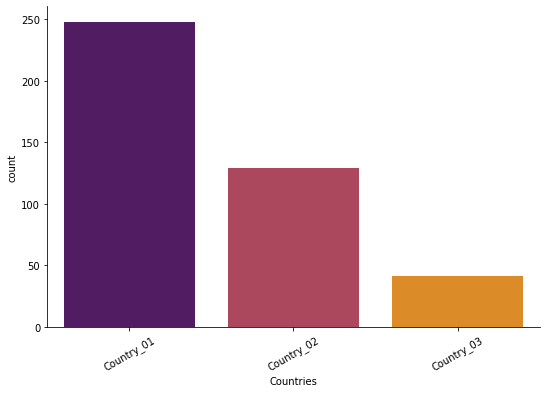

In [ ]:
ax=sns.catplot(x="Countries", kind="count", palette="inferno", data=df,aspect=1.5)
ax.set_xticklabels(rotation=30)

Text(0.5, 1.0, 'Accidents per country')

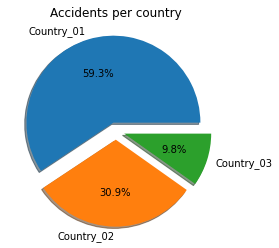

In [ ]:
country= df.groupby('Countries').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per country
plt.pie(country['Data'], labels= country['Countries'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1], radius = 1) 
plt.title("Accidents per country")

### Local
Local_03 (which also belongs to Country_01) is where most of the accidents happen


Text(0.5, 1.0, 'Accidents per locality')

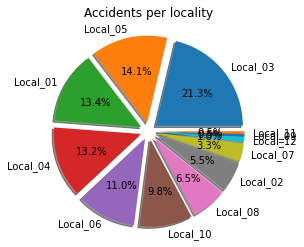

In [ ]:
locality= df.groupby('Local').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per locality
plt.pie(locality['Data'], labels= locality['Local'], autopct='%1.1f%%', shadow = True,explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],  radius = 1) 
plt.title("Accidents per locality")

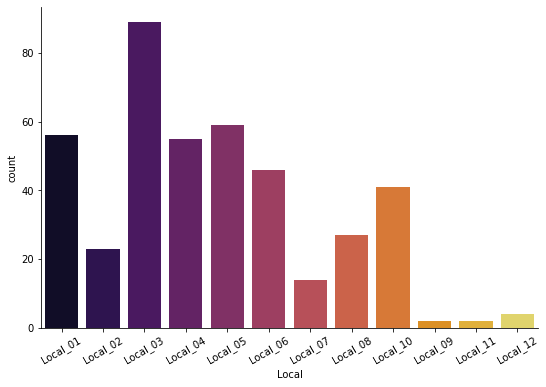

In [ ]:
g=sns.catplot(x="Local", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

### Industry sector

Mining is also the most significant contributor to accidents

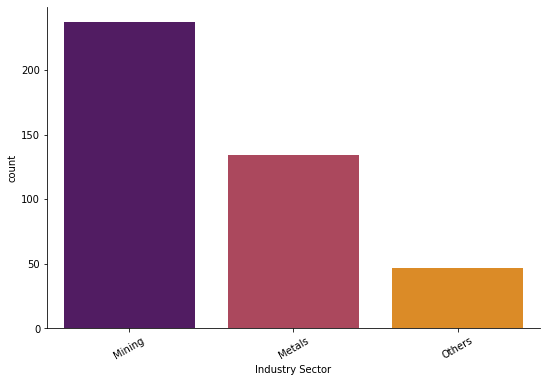

In [ ]:
g=sns.catplot(x="Industry Sector", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, 'Accidents per Industry')

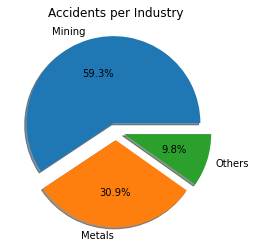

In [ ]:
Industry= df.groupby('Industry Sector').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per country
plt.pie(country['Data'], labels= Industry['Industry Sector'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1], radius = 1) 
plt.title("Accidents per Industry")

### Accident

Accident Level 1 is the most prominent type of accidents(more than 70%) followed by Accident Level 2(less than 10%)

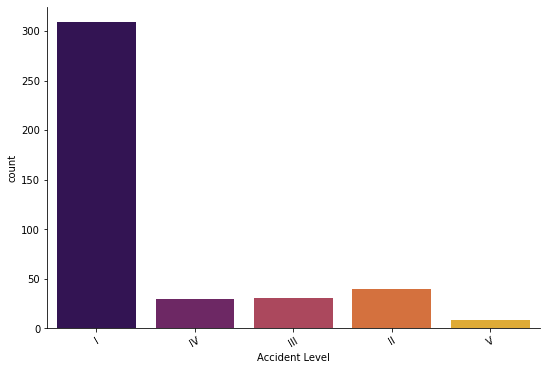

In [ ]:
g=sns.catplot(x="Accident Level", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, 'Accidents per Accident Level')

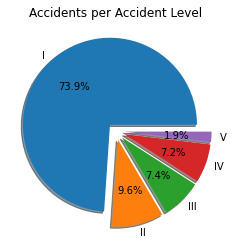

In [ ]:
acc_level= df.groupby('Accident Level').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Accident Level
plt.pie(acc_level['Data'], labels= acc_level['Accident Level'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1,0.1, 0.1], radius = 1) 
plt.title("Accidents per Accident Level")

### Potential Accident Level

Potential Accident Level 4 has the most prominent type of potential accident followed by Accident Level 3 & 2

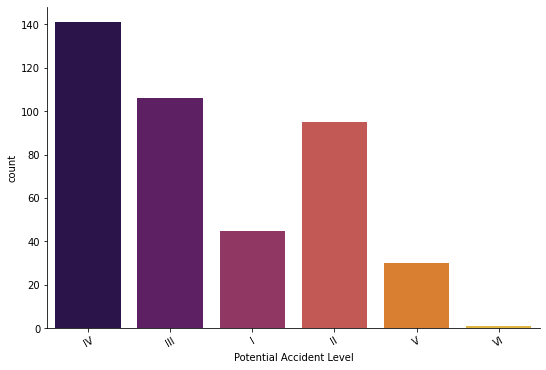

In [ ]:
g=sns.catplot(x="Potential Accident Level", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, 'Potential Accidents per Potential Accident Level')

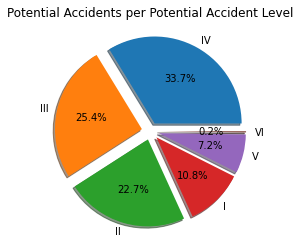

In [ ]:
pot_acc_level= df.groupby('Potential Accident Level').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Potential Accident Level
plt.pie(pot_acc_level['Data'], labels= pot_acc_level['Potential Accident Level'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1,0.1, 0.1, 0.1], radius = 1) 
plt.title("Potential Accidents per Potential Accident Level")

### Gender
Male (95%) counts for kind of people that suffers more accident

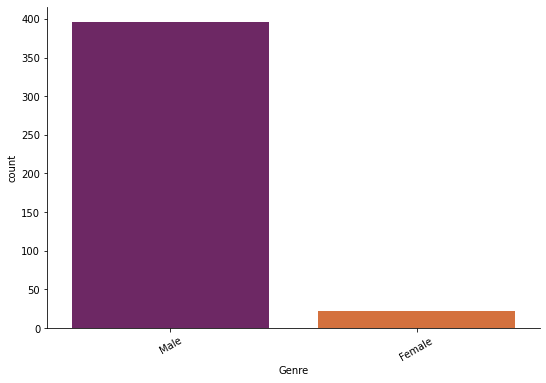

In [ ]:
g=sns.catplot(x="Genre", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, ' Accidents per Gender')

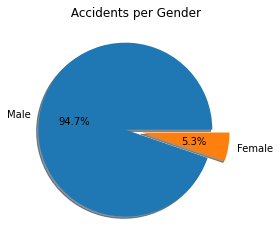

In [ ]:
gender= df.groupby('Genre').count().sort_values(by=['Data'],ascending = False).reset_index()
#Representation per Gender
plt.pie(gender['Data'], labels= gender['Genre'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1], radius = 1) 
plt.title(" Accidents per Gender")

### Employee

Third-Party (44%) counts for kind of people that suffers more accident followed by Employee(42%)

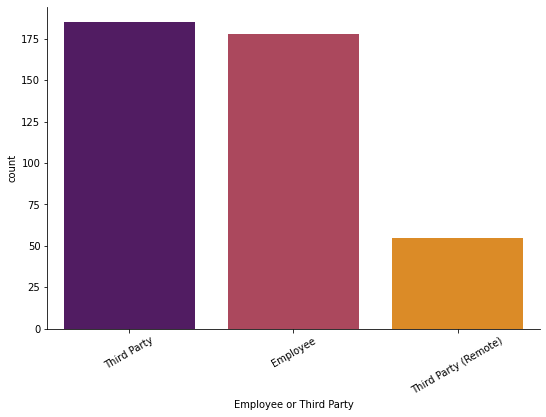

In [ ]:
g=sns.catplot(x="Employee or Third Party", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, ' Accidents per employee_type')

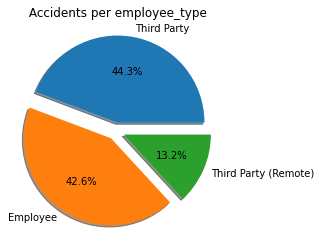

In [ ]:
employee_type= df.groupby('Employee or Third Party').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per employee_type
plt.pie(employee_type['Data'], labels= employee_type['Employee or Third Party'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1], radius = 1) 
plt.title(" Accidents per employee_type")

### Critical Risk

Others(undefined) followed by Pressed & Manual Tools are the major categories in the description of the risk involved in the accident

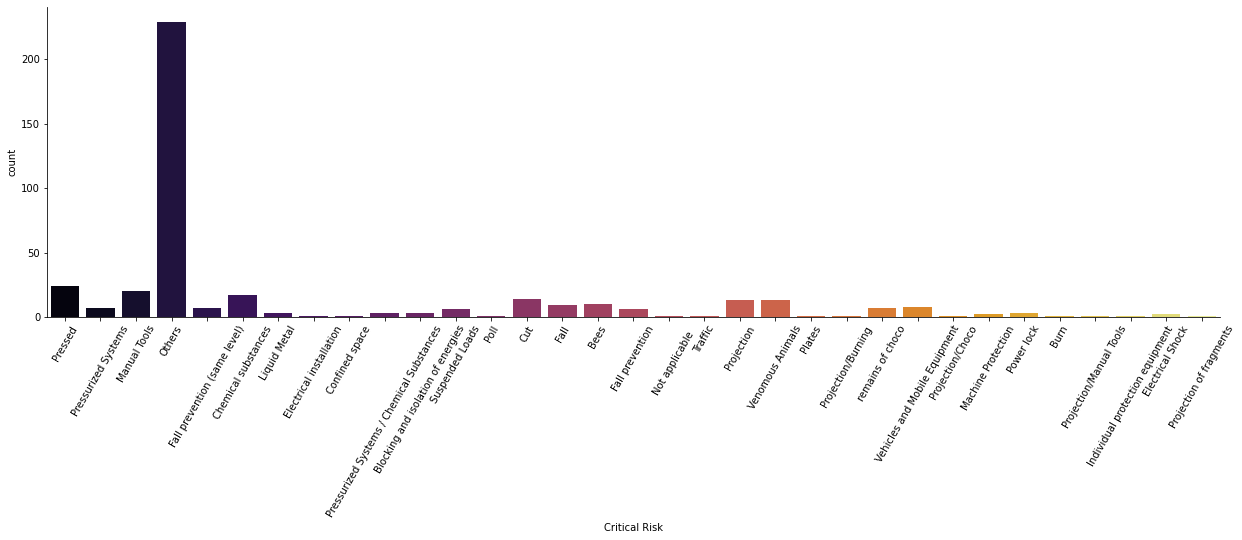

In [ ]:
g=sns.catplot(x="Critical Risk", kind="count", palette="inferno", data=df,aspect=3.5)
g.set_xticklabels(rotation=60)

In [ ]:
df[['Critical Risk']].apply(lambda x: x.value_counts()).T.stack()

Critical Risk  Others                                       229
               Pressed                                       24
               Manual Tools                                  20
               Chemical substances                           17
               Cut                                           14
               Venomous Animals                              13
               Projection                                    13
               Bees                                          10
               Fall                                           9
               Vehicles and Mobile Equipment                  8
               Pressurized Systems                            7
               remains of choco                               7
               Fall prevention (same level)                   7
               Suspended Loads                                6
               Fall prevention                                6
               Liquid Metal             

### Date

#### Year

Most of the accidents happen in 2016(67%). 

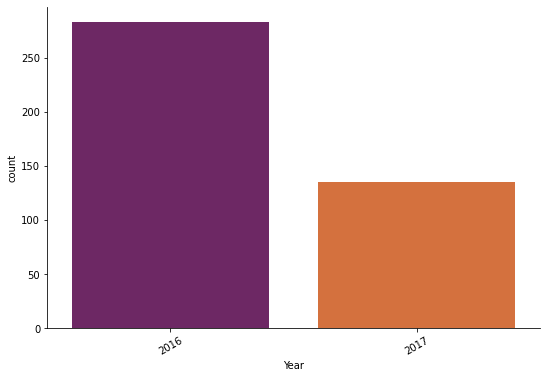

In [ ]:
g=sns.catplot(x="Year", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, ' Accidents per Year')

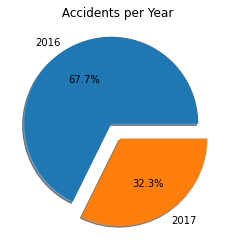

In [ ]:
Year= df.groupby('Year').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Year
plt.pie(Year['Data'], labels= Year['Year'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1], radius = 1) 
plt.title(" Accidents per Year")

#### Month
Most of the accidents happen in Febuary followed by April & June

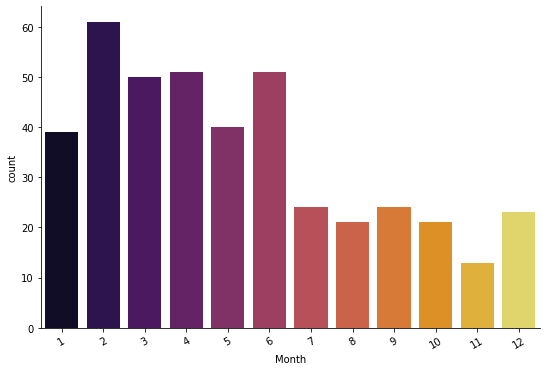

In [ ]:
g=sns.catplot(x="Month", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, ' Accidents per Month')

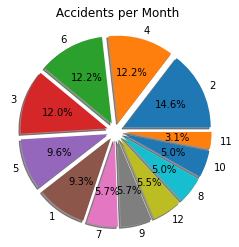

In [ ]:
Month= df.groupby('Month').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Month
plt.pie(Month['Data'], labels= Month['Month'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1,0.1, 0.1, 0.1,0.1, 0.1, 0.1,0.1, 0.1, 0.1], radius = 1) 
plt.title(" Accidents per Month")

#### Day
It can be seen that there are two peaks of accidents on 8th & 4th 

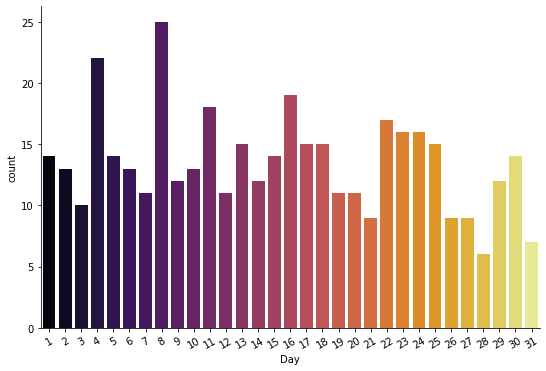

In [ ]:
g=sns.catplot(x="Day", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

#### Weekday

Thursday is the day when most of the accidents happen followed by Tuesday.

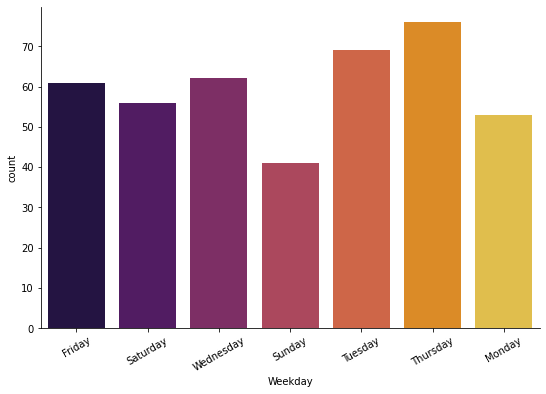

In [ ]:
g=sns.catplot(x="Weekday", kind="count", palette="inferno", data=df,aspect=1.5)
g.set_xticklabels(rotation=30)

Text(0.5, 1.0, ' Accidents per Weekday')

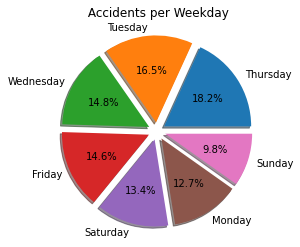

In [ ]:
Weekday= df.groupby('Weekday').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Weekday
plt.pie(Weekday['Data'], labels= Weekday['Weekday'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1,0.1, 0.1, 0.1,0.1], radius = 1) 
plt.title(" Accidents per Weekday")

#### Week of the Year

It can be seen that the peak of accidents is in 7th week of the year

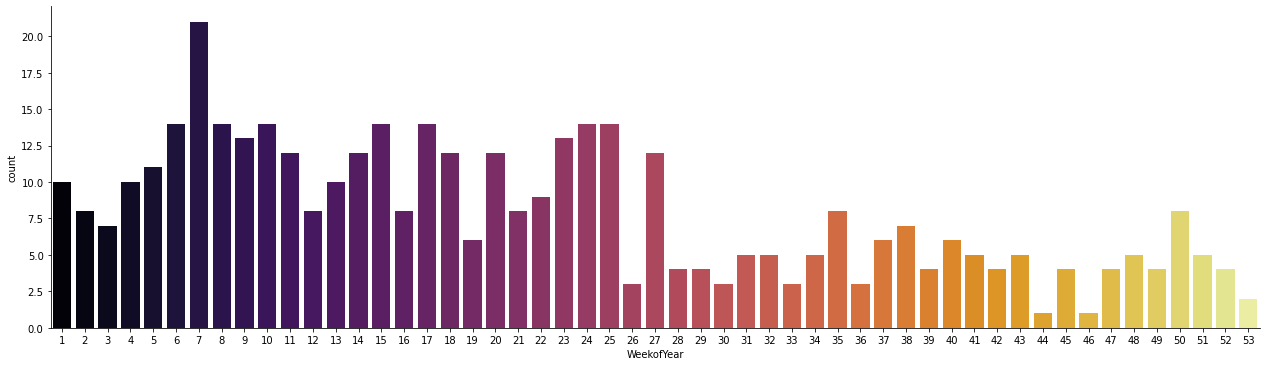

In [ ]:
g=sns.catplot(x="WeekofYear", kind="count", palette="inferno", data=df,aspect=3.5)
g.set_xticklabels(rotation=0)


####Accident Per Season
Piechart shows accident across the seasons. Autumn season accounts for 34% of the total accidents

Text(0.5, 1.0, ' Accidents per Season')

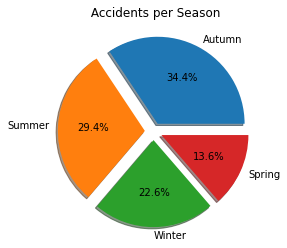

In [ ]:
Season= df.groupby('Season').count().sort_values(by=['Data'],ascending = False).reset_index()

#Representation per Season
plt.pie(Season['Data'], labels= Season['Season'], autopct='%1.1f%%', shadow = True, explode = [0.1, 0.1, 0.1,0.1], radius = 1) 
plt.title(" Accidents per Season")

## Accident (Target) Distribution Analysis


### Target Distribution 

Rectangle(xy=(-0.4, 0), width=0.8, height=309, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=30, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=31, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=40, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=8, angle=0)


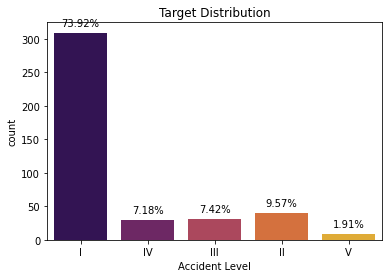

In [ ]:
#plt.figure(figsize=(70,10))

plt.title('Target Distribution')
ax=sns.countplot(data = df, x= 'Accident Level',palette='inferno') 
for p in ax.patches: 
    print(p)
    ax.annotate(str((np.round(p.get_height()/len(df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



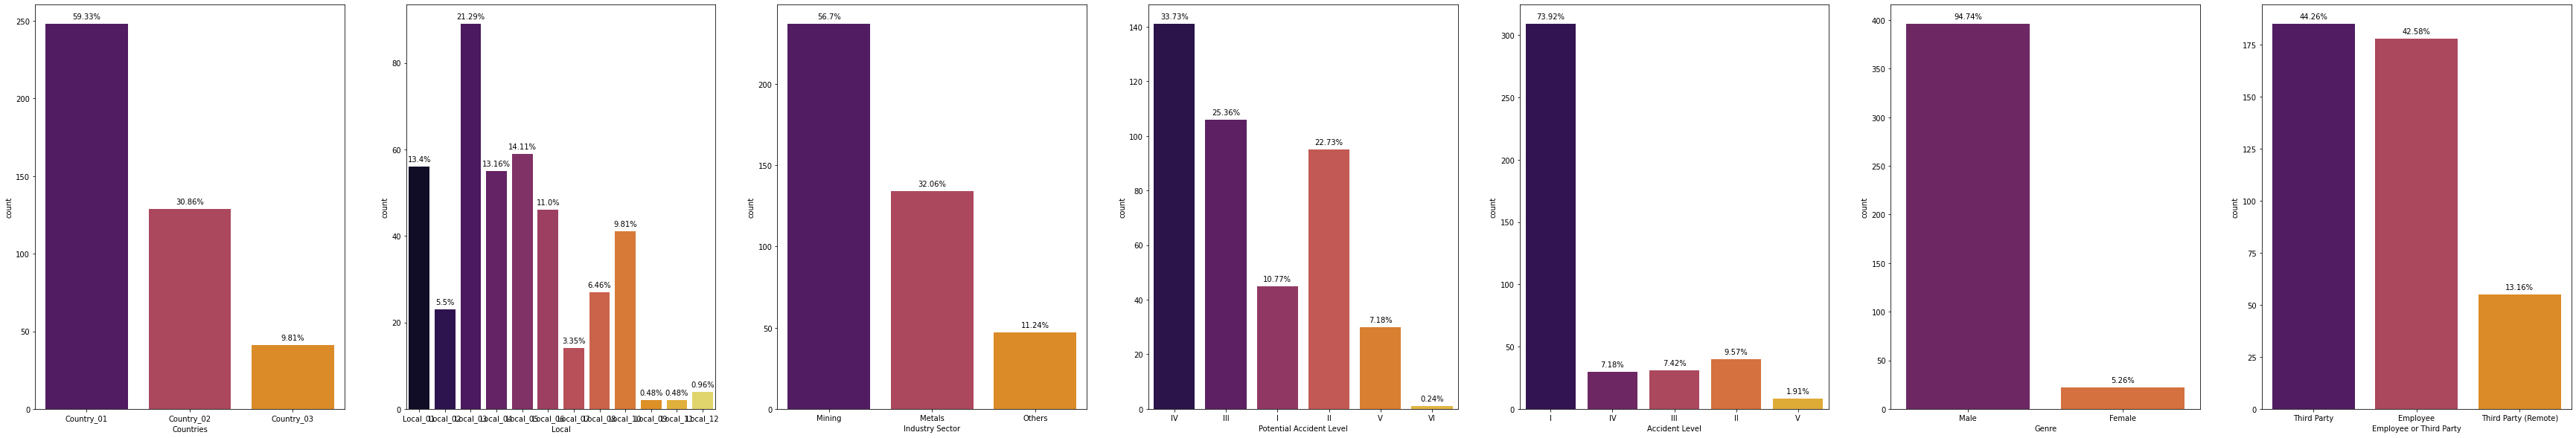

In [ ]:
categorcial_variables = ['Countries','Local','Industry Sector','Potential Accident Level','Accident Level','Genre','Employee or Third Party']

plt.figure(figsize=(70,10))
j = range(len(categorcial_variables))
for i in j:
    plt.subplot(1, 8, i+1)
    ax=sns.countplot(data = df,palette='inferno', x= categorcial_variables[i]) 
    for p in ax.patches: 
        ax.annotate(str((np.round(p.get_height()/len(df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')




### Stacked plots between Accident Level & other categories
1) Country_01 is the country where most of the accidents and Accident Level 1 happen
2) Local_03 (which also belongs to Country_01) followed by Local_5 are the places where most of the accidents happen
3)Male (95%) and Third-Party (43%) also counts for kind of people that suffers more accidents




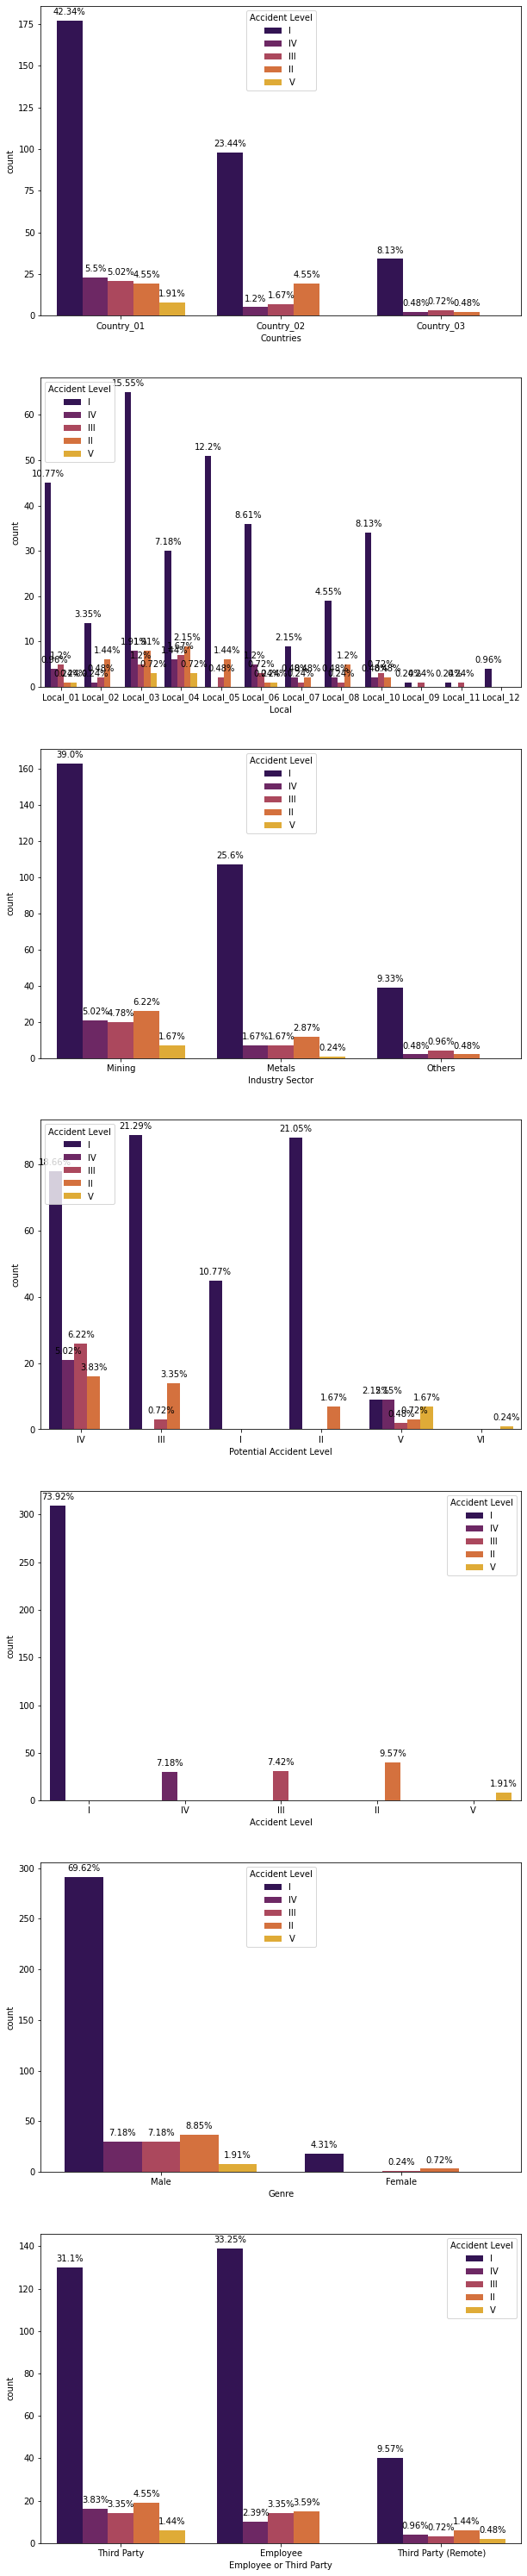

In [ ]:
plt.figure(figsize=(10,70))
p = range(len(categorcial_variables))
for i in p:
    plt.subplot(9, 1, i+1)
    ax=sns.countplot(data = df, x= categorcial_variables[i],palette='inferno',hue = 'Accident Level') 
    for p in ax.patches: 
       ax.annotate(str((np.round(p.get_height()/len(df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
 


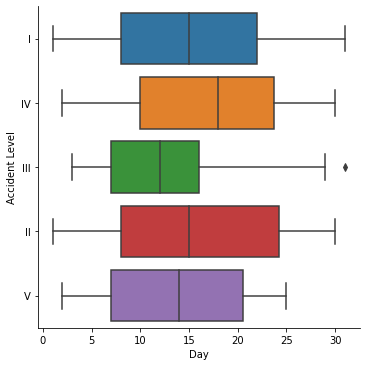

In [ ]:
sns.catplot(x="Day", y="Accident Level", kind="box", data=df) 

Text(0.5, 1.0, ' Accidents per Season')

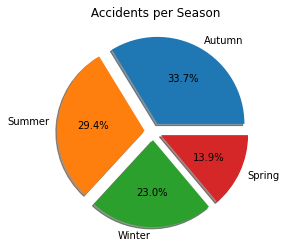

##Potential Accident(Target) Distribution Analysis

###Target Distribution

Rectangle(xy=(-0.4, 0), width=0.8, height=143, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=106, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=49, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=95, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=31, angle=0)
Rectangle(xy=(4.6, 0), width=0.8, height=1, angle=0)


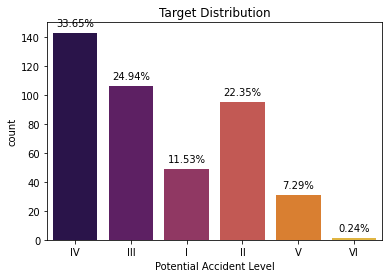

In [ ]:
#plt.figure(figsize=(70,10))

plt.title('Target Distribution')
ax=sns.countplot(data = df, x= 'Potential Accident Level',palette='inferno') 
for p in ax.patches: 
    print(p)
    ax.annotate(str((np.round(p.get_height()/len(df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



###Stacked Plots between Patential Accident Level & other categories
1) Potential Accident Level 4 is the most prominent among all.
2) Potental Accident Level 4 is prominent in Mining whereas level 2 is in Metal. Others have maximum Potential Accident Level 1 cases
3) Males are suffering more from Potential Accident Level 4 accidents whereas Level 2 is prominent among females
4) There are many accidents with minor severity levels, but could be potentially more severe.


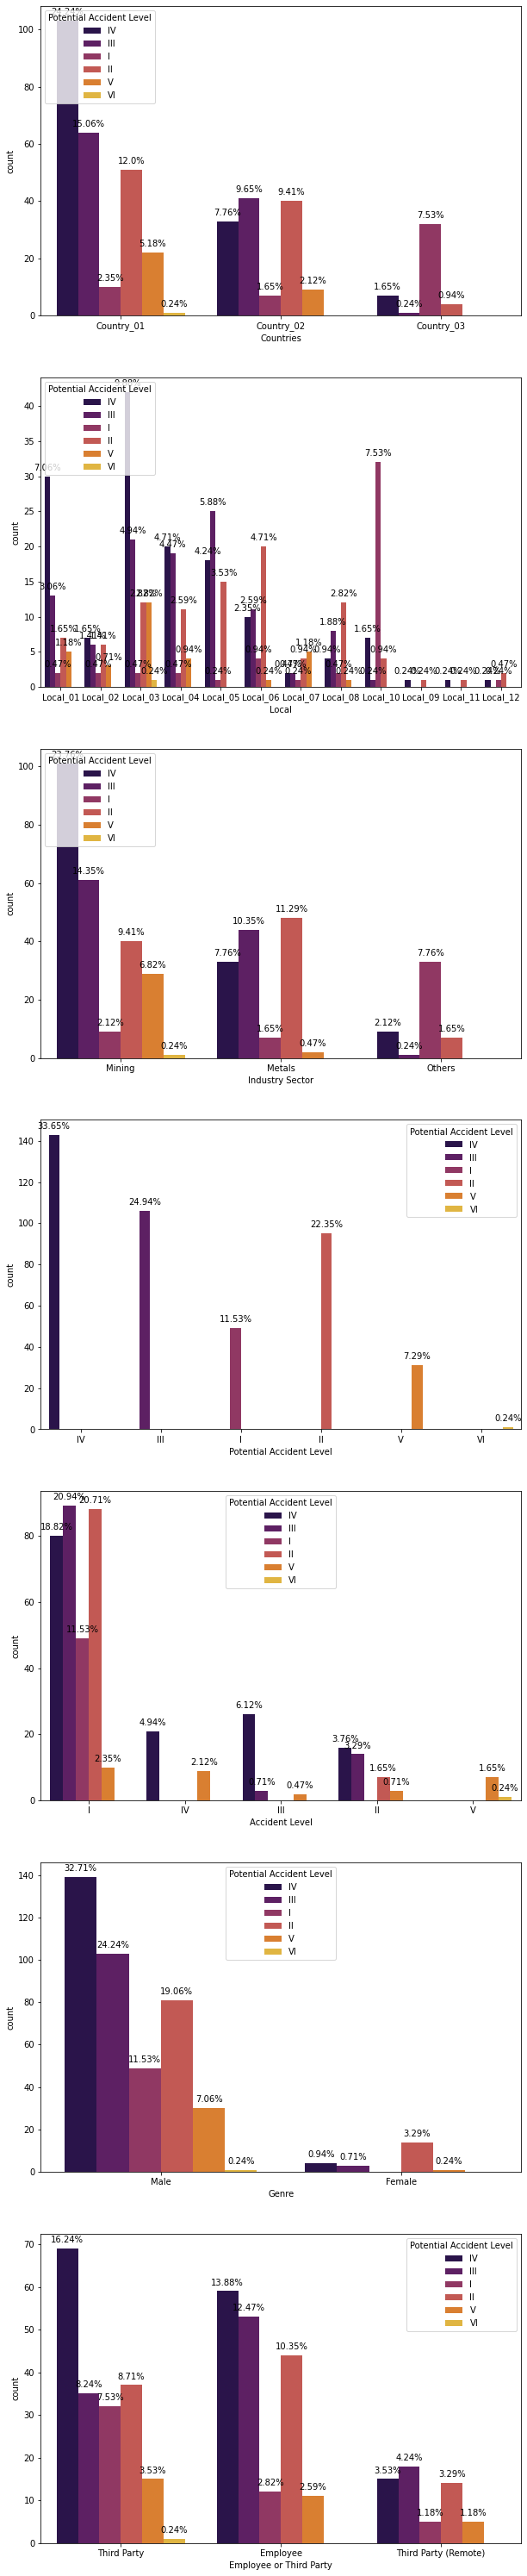

In [ ]:
plt.figure(figsize=(10,70))
p = range(len(categorcial_variables))
for i in p:
    plt.subplot(9, 1, i+1)
    ax=sns.countplot(data = df, x= categorcial_variables[i],palette='inferno',hue = 'Potential Accident Level') 
    for p in ax.patches: 
       ax.annotate(str((np.round(p.get_height()/len(df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
 

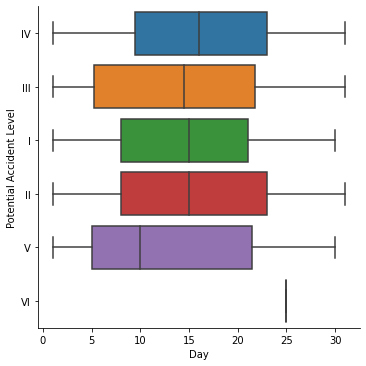

In [ ]:
sns.catplot(x="Day", y="Potential Accident Level", kind="box", data=df) 

In [ ]:
level_map = {'I': 1, 'II': 2,'III': 3 , 'IV' : 4, 'V': 5, 'VI' : 6}
df['Potential Accident Level'] = pd.Series([level_map[x] for x in df['Potential Accident Level']], index=df.index)

Ratio of level 1 incedents to level 2+ incedents:  0.13 


4    143
3    106
2     95
1     49
5     31
6      1
Name: Potential Accident Level, dtype: int64


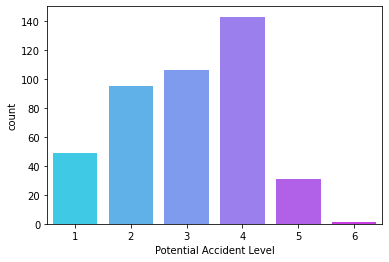

In [ ]:
sns.countplot(x='Potential Accident Level', data=df, palette='cool')
acc_level = df['Potential Accident Level'].value_counts()
print("Ratio of level 1 incedents to level 2+ incedents: ",round(acc_level[1]/(acc_level.sum()-acc_level[1]), 3),'\n\n')
print(acc_level)

In [ ]:
acc_level = df.loc[df['Employee or Third Party'] == 'Third Party']['Potential Accident Level'].value_counts()
print("Ratio of level 1 incedents to level 2+ incedents, Third Party: ",round(acc_level[1]/(acc_level.sum()-acc_level[1]), 3),'\n\n')
print(acc_level)

Ratio of level 1 incedents to level 2+ incedents, Third Party:  0.204 


4    69
2    37
3    35
1    32
5    15
6     1
Name: Potential Accident Level, dtype: int64





Ratio of level 1 incedents to level 2+ incedents, Third Party (Remote):  0.096 


3    18
4    15
2    14
5     5
1     5
Name: Potential Accident Level, dtype: int64


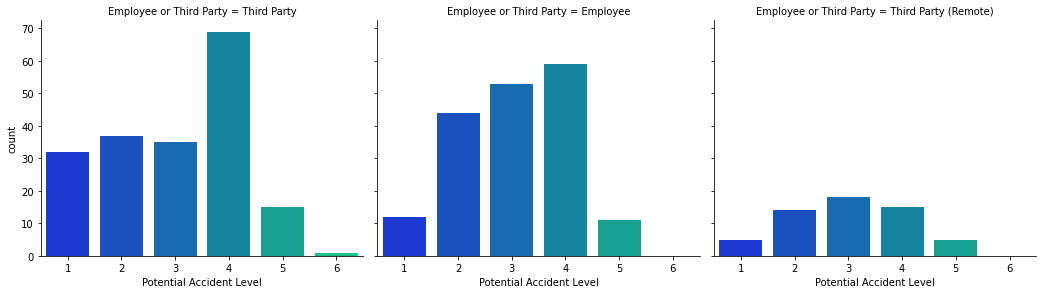

In [ ]:
acc_level = df.loc[df['Employee or Third Party'] == 'Third Party (Remote)']['Potential Accident Level'].value_counts()
print("\n\n\nRatio of level 1 incedents to level 2+ incedents, Third Party (Remote): ",round(acc_level[1]/(acc_level.sum()-acc_level[1]), 3),'\n\n')
print(acc_level)

sns.catplot(x="Potential Accident Level",col="Employee or Third Party",

                data=df, kind="count",

                height=4, aspect=1.2, palette='winter')

2    14
4     4
3     3
5     1
Name: Potential Accident Level, dtype: int64


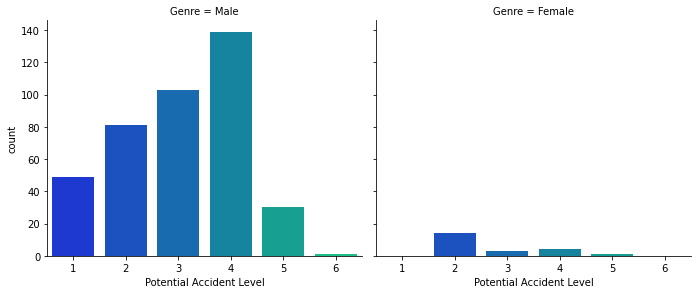

In [ ]:
acc_level = df.loc[df['Genre'] == 'Female']['Potential Accident Level'].value_counts()
print(acc_level)

sns.catplot(x="Potential Accident Level", col="Genre",

                data=df, kind="count",

                height=4, aspect=1.2, palette='winter')

Incedents by possible factor: Industry Sector


Mining    241
Metals    134
Others     50
Name: Industry Sector, dtype: int64

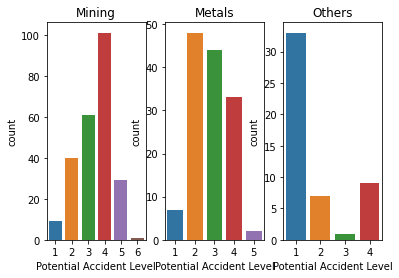

In [ ]:
print('Incedents by possible factor: Industry Sector')
display(df['Industry Sector'].value_counts())


fig, ax =plt.subplots(1,3)
ax[0].set_title('Mining')
sns.countplot(df['Potential Accident Level'].loc[df['Industry Sector'] == 'Mining'], ax=ax[0])
ax[1].set_title('Metals')
sns.countplot(df['Potential Accident Level'].loc[df['Industry Sector'] == 'Metals'], ax=ax[1])
ax[2].set_title('Others')
sns.countplot(df['Potential Accident Level'].loc[df['Industry Sector'] == 'Others'], ax=ax[2])

In [21]:
#df.pivot_table(index = 'Potential Accident Level',columns= 'Accident Level',aggfunc=np.sum)
df.pivot_table(
    values='Data', index='Accident Level', columns='Potential Accident Level',
    fill_value=0, aggfunc='count')

Potential Accident Level   I  II  III  IV   V  VI
Accident Level                                   
I                         49  88   89  80  10   0
II                         0   7   14  16   3   0
III                        0   0    3  26   2   0
IV                         0   0    0  21   9   0
V                          0   0    0   0   7   1

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Inferences on EDA

*  "cm", "kg", "mr", "wa" ,"nv", "ore", "da", "pm", "am", "cx" are contained in the data far too frequently and do not convey information about the severity levels , so we will add them to the stop words

causing, hand, left, right , operator are the most frequently used unigrams in Cleaned description corpus

left hand ,time accident, right hand,causing injury and finger left are the most frequently used bigrams in Cleaned description corpus

finger left hand	,injury time accident,	finger right hand,time accident employeeand described time accident are the most frequently used trigrams in Cleaned description corpus

Description ranges from 5 words to 95 words

73.9% of the accidents are minor accidents , there are only 1.9% major accidents of all the accidents

The numbers of accidents that third party , remote workers were involved in is higher as compared to employees

A lot of the accidents have critical risk captured as others which does not provide any information, we need to consider these as missing values and impute them

There are several words that are related to hands. For example, left, hand, right, and finger.

Moreover, there are several words that are related to the movement of something. For example, hit, remove, fall, and move.

There are also some phrases that are related to other body parts. For example, left foot and right leg.


# Description classification: LSA and LDA

In [ ]:
# Text preprocessing and stopwords
from text_preprocess import * #(custom module)

print('--'*30); print('Converting headlines to lower case')
df['cleaned_Description'] = df['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Removing Numbers')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

print('Applying Lemmatizer')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

print('Removing stopwords')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x: remove_stopwords(x))

# remove short words (length < 3)
print('Removing short words')
df['cleaned_Description'] = df['cleaned_Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
print('--'*30)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


## Features extraction 1- LSA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(df['cleaned_Description'])

X.shape # check shape of the document-term matrix

(418, 1000)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")

Topic 0: 
hand
employee
causing
left
right
operator
time
 
Topic 1: 
mesh
operator
assistant
support
time
worker
level
 
Topic 2: 
activity
reaction
team
area
sting
allergic
vehicle
 
Topic 3: 
pipe
rock
air
flange
activity
reaching
pump
 
Topic 4: 
pump
operator
equipment
reaching
solution
maintenance
acid
 
Topic 5: 
mesh
rock
support
report
employee
fragment
cut
 
Topic 6: 
pump
bar
mesh
assistant
hose
support
equipment
 
Topic 7: 
operator
equipment
bar
truck
pipe
piece
hit
 
Topic 8: 
car
hopper
time
collaborator
accident
activity
locomotive
 
Topic 9: 
mesh
medical
sheet
face
cathode
cut
hose
 


## Feature extraction 2-- LDA

In [ ]:
from nltk import FreqDist
import gensim
from gensim import corpora
import spacy
import pyLDAvis
#import pyLDAvis.gensim

In [ ]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

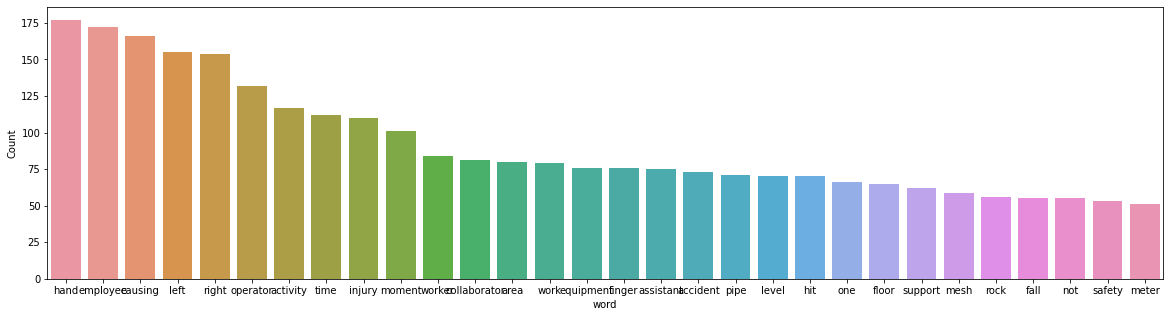

In [ ]:
freq_words(df.cleaned_Description)

In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [ ]:
tokenized_desc = pd.Series(df.cleaned_Description).apply(lambda x: x.split())
print(tokenized_desc[1])

['activation', 'sodium', 'sulphide', 'pump', 'piping', 'uncoupled', 'sulfide', 'solution', 'designed', 'area', 'reach', 'maid', 'immediately', 'made', 'use', 'emergency', 'shower', 'directed', 'ambulatory', 'doctor', 'later', 'hospital', 'note', 'sulphide', 'solution', 'gram', 'liter']


In [ ]:
print(tokenized_desc[1])
len(tokenized_desc[1])

['activation', 'sodium', 'sulphide', 'pump', 'piping', 'uncoupled', 'sulfide', 'solution', 'designed', 'area', 'reach', 'maid', 'immediately', 'made', 'use', 'emergency', 'shower', 'directed', 'ambulatory', 'doctor', 'later', 'hospital', 'note', 'sulphide', 'solution', 'gram', 'liter']


27

In [ ]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(tokenized_desc)

In [ ]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_desc]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [ ]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=15, 
                random_state=100,
                chunksize=1000,
                passes=50)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
lda_model.print_topics()

[(0,
  '0.017*"hit" + 0.015*"causing" + 0.011*"employee" + 0.009*"activity" + 0.008*"left" + 0.008*"pump" + 0.007*"operator" + 0.006*"injury" + 0.006*"hand" + 0.006*"circumstance"'),
 (1,
  '0.017*"operator" + 0.010*"right" + 0.009*"one" + 0.009*"hand" + 0.008*"truck" + 0.007*"left" + 0.007*"pipe" + 0.006*"causing" + 0.006*"area" + 0.006*"face"'),
 (2,
  '0.017*"hand" + 0.016*"employee" + 0.015*"bar" + 0.015*"one" + 0.012*"left" + 0.012*"moment" + 0.009*"collaborator" + 0.008*"causing" + 0.008*"finger" + 0.008*"rod"'),
 (3,
  '0.017*"mesh" + 0.016*"operator" + 0.014*"left" + 0.011*"causing" + 0.011*"time" + 0.011*"right" + 0.009*"platform" + 0.009*"activity" + 0.008*"accident" + 0.008*"support"'),
 (4,
  '0.016*"hand" + 0.015*"time" + 0.013*"worker" + 0.013*"collaborator" + 0.011*"right" + 0.010*"causing" + 0.010*"team" + 0.009*"accident" + 0.009*"car" + 0.009*"rock"'),
 (5,
  '0.018*"activity" + 0.014*"employee" + 0.012*"area" + 0.011*"vehicle" + 0.011*"causing" + 0.009*"cut" + 0.008*

# Re-classify Risk category with Others

Reasons to perform the activity: 

*  Risk category being the most diversified column and majority of them were given as Other. Our aim is to assess the others category with the help of description provided.

* We performed LDA (Linear discriminant analysis) and LSA (Latent semantic analysis) on Description column which doesnt seem to yeild any inferable results.

*  As the data is very low in volume, we tried to achieve this with the help of data augmentation and classification with hyper parameter tuning.



In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')

In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
from text_preprocess import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

#Lable Encoder to change the categorical values to numerical values.
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

rm: cannot remove 'log/': No such file or directory


## Load augmented data
* This is augmented due to limited dataset which was provided.

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_Aug.csv')

data = pd.read_csv('/content/drive/MyDrive/Capstone project/cat_train.csv')
val = pd.read_csv('/content/drive/MyDrive/Capstone project/cat_val.csv')
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head(3))

Data has 469 rows and 11 columns. Here are the first five rows of the data...


Unnamed: 0  ...                                        Description
0          14  ...  Due to the accumulation of Waelz on the convey...
1          91  ...  When performing the sleeve removal maneuver, w...
2         191  ...  At the EusÃ©bio bridge, there was a sudden bra...

[3 rows x 11 columns]

In [ ]:
data_bkp = data.copy

In [ ]:
print('Dropping Unnamed: 0 column')
data.drop(['Unnamed: 0'],axis =1,inplace = True)

Dropping Unnamed: 0 column


In [ ]:
print('Dropping duplicates')
#data.drop_duplicates(inplace=True)

Dropping duplicates


In [ ]:
data.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
data['SNo']= data.index+1
_='''data['Date'] =  pd.to_datetime(data['Date'], infer_datetime_format=True)
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.day_name()
data.reset_index(inplace=True)
data.info()
'''

In [ ]:
data

Date  ...  SNo
0      2/4/2016 0:00  ...    1
1     3/24/2016 0:00  ...    2
2     7/21/2016 0:00  ...    3
3    11/13/2016 0:00  ...    4
4      1/8/2017 0:00  ...    5
..               ...  ...  ...
464   5/18/2017 0:00  ...  465
465   6/11/2017 0:00  ...  466
466   6/14/2017 0:00  ...  467
467   6/29/2017 0:00  ...  468
468   6/17/2016 0:00  ...  469

[469 rows x 11 columns]

In [ ]:
risk_map = {'\nNot applicable': 99,
'Bees': 1,
'Venomous Animals': 1,
'Blocking and isolation of energies': 3,
'Burn': 3,
'Confined space': 3,
'Cut': 3,
'Machine Protection': 3,
'Manual Tools': 3,
'Poll': 3,
'Projection': 3,
'Projection of fragments': 3,
'Projection/Burning': 3,
'Projection/Choco': 3,
'Projection/Manual Tools': 3,
'remains of choco': 3,
'Suspended Loads': 3,
'Fall': 4,
'Fall prevention': 4,
'Fall prevention (same level)': 4,
'Electrical installation': 5,
'Electrical Shock': 5,
'Plates': 5,
'Power lock': 5,
'Chemical substances': 6,
'Liquid Metal': 7,
'Pressed': 8,
'Pressurized Systems': 8,
'Pressurized Systems / Chemical Substances': 8,
'Individual protection equipment': 9,
'Traffic': 10,
'Vehicles and Mobile Equipment': 11,
'Others': 99}
data['Critical Risk'] = pd.Series([risk_map[x] for x in data['Critical Risk']], index=data.index)

### Description Clean up

In [ ]:
data = data[['SNo','Description','Critical Risk']]

In [ ]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_Description'] = data['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Removing Numbers')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

print('Applying Lemmatizer')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

print('Removing stopwords')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x: remove_stopwords(x))

# remove short words (length < 3)
print('Removing short words')
data['cleaned_Description'] = data['cleaned_Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


## Load augmented Val data
* This is augmented due to limited dataset which was provided.

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_Aug.csv')

val = pd.read_csv('/content/drive/MyDrive/Capstone project/cat_val.csv')
print(f'Data has {val.shape[0]} rows and {val.shape[1]} columns. Here are the first five rows of the data...')
display(val.head(3))

Data has 13 rows and 11 columns. Here are the first five rows of the data...


Unnamed: 0  ...                                        Description
0          13  ...  In moments that the operator of the Jumbo 2, t...
1         336  ...  When averaging 04:30 am, the operator Daniel r...
2          12  ...  The collaborator reports that he was working i...

[3 rows x 11 columns]

In [ ]:
print('Dropping Unnamed: 0 column')
val.drop(['Unnamed: 0'],axis =1,inplace = True)

Dropping Unnamed: 0 column


In [ ]:
print('Dropping duplicates')
#data.drop_duplicates(inplace=True)

Dropping duplicates


In [ ]:
val.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
val['SNo']= val.index+1
_='''data['Date'] =  pd.to_datetime(data['Date'], infer_datetime_format=True)
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.day_name()
data.reset_index(inplace=True)
data.info()
'''

In [ ]:
val

Date  ... SNo
0    2/2/2016 0:00  ...   1
1    2/8/2017 0:00  ...   2
2    2/1/2016 0:00  ...   3
3    3/9/2016 0:00  ...   4
4    1/2/2016 0:00  ...   5
5   1/29/2017 0:00  ...   6
6   5/24/2016 0:00  ...   7
7   5/25/2016 0:00  ...   8
8   8/14/2016 0:00  ...   9
9   4/17/2016 0:00  ...  10
10  1/26/2016 0:00  ...  11
11   1/6/2016 0:00  ...  12
12   1/1/2016 0:00  ...  13

[13 rows x 11 columns]

In [ ]:
val['Critical Risk'] = pd.Series([risk_map[x] for x in val['Critical Risk']], index=val.index)

In [ ]:
data_val = val[['SNo','Description','Critical Risk']]

### Description Clean up

In [ ]:
print('--'*30); print('Converting headlines to lower case')
data_val['cleaned_Description'] = data_val['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Removing Numbers')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

print('Applying Lemmatizer')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

print('Removing stopwords')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x: remove_stopwords(x))

# remove short words (length < 3)
print('Removing short words')
data_val['cleaned_Description'] = data_val['cleaned_Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


## Load actual data to prepare our final dataset
* Based on actual file provided

In [ ]:
#ram risk_data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset.csv')
risk_data_df = pd.read_csv('/content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv')
risk_data_df.drop(['Unnamed: 0'],axis =1,inplace = True)
risk_data_df.rename(columns={'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)
risk_data_df['Critical Risk'] = pd.Series([risk_map[x] for x in risk_data_df['Critical Risk']], index=risk_data_df.index)

# Others
without_risk_df = risk_data_df[risk_data_df['Critical Risk'] == 99].reset_index(drop=True)

# Non-others where actual data was provided
with_risk_df = risk_data_df[risk_data_df['Critical Risk'] != 99].reset_index(drop=True)

#with_risk_df.drop(columns = 'Critical_Risk',axis= 1, inplace=True)

In [ ]:
without_risk_df = without_risk_df[without_risk_df['Critical Risk'] == 99].reset_index(drop=True)
without_risk_df.drop(columns=['Critical Risk'],axis=1,inplace=True)

In [ ]:
without_risk_df.head(2)

Date  ... Critical Risk
0  2016-01-08 00:00:00  ...             3
1  2016-01-10 00:00:00  ...             3

[2 rows x 10 columns]

### Description Clean up

In [ ]:
print('--'*30); print('Converting headlines to lower case')
without_risk_df['cleaned_Description'] = without_risk_df['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Removing Numbers')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

print('Applying Lemmatizer')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

print('Removing stopwords')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x: remove_stopwords(x))

# remove short words (length < 3)
print('Removing short words')
without_risk_df['cleaned_Description'] = without_risk_df['cleaned_Description'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


## Calculate words and line size on cleaned text

In [ ]:
# Get length of each line
data['line_length'] = data['cleaned_Description'].str.len()

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))

Minimum line length: 64
Maximum line length: 634


In [ ]:
# Get length of each line
data['nb_words'] = data['cleaned_Description'].apply(lambda x: len(x.split(' ')))



print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))

Minimum number of words: 10
Maximum number of words: 93


## Others and Non-other category wise data split

In [ ]:
#Test = data[data['Critical Risk'] == 99].reset_index(drop=True)
Train = data[data['Critical Risk'] != 99].reset_index(drop=True)

In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SNo                  468 non-null    int64 
 1   Description          468 non-null    object
 2   Critical Risk        468 non-null    int64 
 3   cleaned_Description  468 non-null    object
 4   line_length          468 non-null    int64 
 5   nb_words             468 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 22.1+ KB


In [ ]:
Train.head()

SNo  ... nb_words
0    1  ...       26
1    2  ...       93
2    3  ...       18
3    4  ...       36
4    5  ...       27

[5 rows x 6 columns]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    Train['cleaned_Description'].values, Train['Critical Risk'].values, 
    test_size=0.1, random_state=0)
print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_val.shape[0]))

#X_predict =without_risk_df['cleaned_Description'].values

Training utterances: 421
Validation utterances: 47


## Tokenizer and word embeddings

In [ ]:
max_features = 10000
maxlen = max(data.nb_words)
#embedding_size = 200

In [ ]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(X_train))
tokenizer.fit_on_texts(list(X_val))
tokenizer.fit_on_texts(list(X_val))


In [ ]:
maxlen

93

# Preprocessing Pipeline Code

In [ ]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	print(df.new_col_name[0])

	print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	print('--'*30)
	return(df.new_col_name)

In [ ]:
df1,df2=clean_text(df,"Description")

------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
while removing the drill rod of the jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------


In [ ]:
df['cleaned_description']=df2

In [ ]:
df.head(3)

Unnamed: 0  ...                                cleaned_description
0           0  ...  removing drill rod jumbo maintenance superviso...
1           1  ...  activation sodium sulphide pump piping uncoupl...
2           2  ...  substation milpo located level collaborator ex...

[3 rows x 12 columns]

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

class TextVariableEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
        print("X.shape:",X.shape)
        print("X.head:",X.head())
        print("[self.variables :",self.variables)
        #print("X[self.variables]['Description']",X[self.variables]['Description'])
        print("X['Description']:",X['Description'])
        #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
        X['Cleaned_Description'] = clean_text(X,"Description")
        X=X['Cleaned_Description']
        print("Cleaned_Description",X.head())
        X = tokenizer.texts_to_sequences(X)
        print("Tokenized",X)
        #max_len=max( X['cleaned_Description'].apply(lambda x: len(x.split(' '))))
        max_len=100
        print("max_len",max_len)
        X = pad_sequences(X, maxlen = max_len)
        print("padded",X[0])
        return X

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class TemporalVariableEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
        print("X.shape:",X.shape)
        print("X.head:",X.head())
        print("[self.variables :",self.variables)
        print("X[self.variables]['Data']",X[self.variables]['Data'])
        print("X['Data']:",X['Data'])
        print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
        X['month'] = pd.DatetimeIndex(X[self.variables]['Data']).month
        X['year'] = pd.DatetimeIndex(X[self.variables]['Data']).year
        X['day'] = pd.DatetimeIndex(X[self.variables]['Data']).day
        X['dayname'] = pd.DatetimeIndex(X[self.variables]['Data']).day_name()
        X['weekofyear'] = pd.Int64Index(pd.DatetimeIndex(X[self.variables]['Data']).isocalendar().week)  
        print("###############################X.shape:",X.shape)
        enc_attribs=["month", "year", "day","dayname","weekofyear"]
        X=X.loc[:,enc_attribs]
        print("enc dataframe chk",X.head())
        ##X=X.drop('Data',inplace=True)
        #print("df columns",X.columns())
        one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
        X=one_hot_pipeline.fit_transform(X)
        print("###############################X.shape:",X.shape)
        print("###############################X.head:",X[0,:])
        return X

In [ ]:
#Building the Transformation Pipeline
from sklearn.pipeline import Pipeline
from  sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
#import skmice
dataframe=df
dataframe_x=dataframe.drop(['Accident Level'],axis=1)

'''
#numerical pipeline##################################################
num_attribs=["age","balance","day","campaign","previous","pdays"]#"day",#Removing pdays as pdays and previous are multi collinear
dataframe_num=dataframe.loc[:,["age","balance","day","campaign","previous","pdays"]]#"day",
print("Dataframe_num chk" ,dataframe_num.head())
num_pipeline= Pipeline([
            ( 'imputer' ,SimpleImputer(missing_values=-1,strategy='mean')),
            ('std_scaler', StandardScaler ())           
])
dataframe_num_tr=num_pipeline.fit_transform(dataframe_num)
print("Numerical Pipeline check",dataframe_num_tr[0,1])
######################################################################
'''
#date pipeline##################################################
date_attribs=["Data"]
dataframe_date=dataframe.loc[:,date_attribs]#"day",
print("dataframe_date chk" ,dataframe_date.head())
date_pipeline= Pipeline([('date_info_split', TemporalVariableEstimator(date_attribs))])
dataframe_date_tr=date_pipeline.fit_transform(dataframe_date)
print("Date Pipeline check",dataframe_date_tr)
######################################################################
#OnehotEncoding Pipeline##############################################
one_hot_attribs=["Local", "Industry Sector", "Employee or Third Party","Countries","Potential Accident Level","Genre"]
dataframe_onehot=dataframe.loc[:,["Local", "Industry Sector", "Employee or Third Party","Countries","Potential Accident Level","Genre"]]
print("Onehot dataframe chk",dataframe_onehot.head())
one_hot_pipeline= Pipeline([
                        ('one_hot_encoder',OneHotEncoder(drop='first'))
])
dataframe_oh_tr=one_hot_pipeline.fit_transform(dataframe_onehot)
one_hot_pipeline= Pipeline([
                       ('one_hot_encoder',OneHotEncoder())
])
dataframe_oh_tr=one_hot_pipeline.fit_transform(dataframe_onehot)
print("Onehot Pipeline check",dataframe_oh_tr[0,1])
######################################################################
'''
#BinaryEncoding Pipeline##############################################
bin_enc_attribs=["job","month"]
dataframe_bin_enc=dataframe.loc[:,["job","month"]]
print("Binary encode  dataframe chk",dataframe_bin_enc.head())
bin_enc_pipeline= Pipeline([
                        ('bin_enc_encoder',category_encoders.BinaryEncoder())
])
dataframe_bin_enc_tr=bin_enc_pipeline.fit_transform(dataframe_bin_enc)
print("Binary encoding Pipeline check",dataframe_bin_enc_tr.head(1))
######################################################################

#OrdinalEncoding Pipeline##############################################
ord_enc_attribs=['education','default','housing','loan','poutcome']
dataframe_ord_enc=dataframe.loc[:,['education','default','housing','loan','poutcome']]
print("Ordinal encode  dataframe chk",dataframe_ord_enc.head())
ord_enc_pipeline= Pipeline([
                        ('ord_enc_encoder',OrdinalEncoder())
])
dataframe_ord_enc_tr=ord_enc_pipeline.fit_transform(dataframe_ord_enc)
print("Ordinal encoding Pipeline check",dataframe_ord_enc_tr[0,:])
######################################################################
'''
#Text Pipeline##############################################
text_attribs=['Description']
dataframe_text_enc=dataframe.loc[:,text_attribs]
print("Text encode  dataframe chk",dataframe_text_enc.head())
text_pipeline= Pipeline([('text_encoder',TextVariableEstimator())#,('tokenizer',Tokenizer (num_words = 100))
])
dataframe_text_enc_tr=text_pipeline.fit_transform(dataframe_text_enc)
print("Text encoding Pipeline check",dataframe_text_enc_tr[0])
######################################################################
full_pipeline=ColumnTransformer([
                #("num",num_pipeline,num_attribs),
                ("datetransform",date_pipeline,date_attribs),
                ("textencode",text_pipeline,text_attribs)  ,
                ("onehotencode",one_hot_pipeline, one_hot_attribs) 
                        
                #("ordinalencode",ord_enc_pipeline,ord_enc_attribs) ,
                #("labelencode",lab_enc_pipeline,label_enc_attribs)

])
dataframe_x_tr=full_pipeline.fit_transform(dataframe_x)
dataframe_x_tr[0,:]


dataframe_date chk                   Data
0  2016-01-01 00:00:00
1  2016-01-02 00:00:00
2  2016-01-06 00:00:00
3  2016-01-08 00:00:00
4  2016-01-10 00:00:00
X.shape: (425, 1)
X.head:                   Data
0  2016-01-01 00:00:00
1  2016-01-02 00:00:00
2  2016-01-06 00:00:00
3  2016-01-08 00:00:00
4  2016-01-10 00:00:00
[self.variables : ['Data']
X[self.variables]['Data'] 0      2016-01-01 00:00:00
1      2016-01-02 00:00:00
2      2016-01-06 00:00:00
3      2016-01-08 00:00:00
4      2016-01-10 00:00:00
              ...         
420    2017-07-04 00:00:00
421    2017-07-04 00:00:00
422    2017-07-05 00:00:00
423    2017-07-06 00:00:00
424    2017-07-09 00:00:00
Name: Data, Length: 425, dtype: object
X['Data']: 0      2016-01-01 00:00:00
1      2016-01-02 00:00:00
2      2016-01-06 00:00:00
3      2016-01-08 00:00:00
4      2016-01-10 00:00:00
              ...         
420    2017-07-04 00:00:00
421    2017-07-04 00:00:00
422    2017-07-05 00:00:00
423    2017-07-06 00:00:00
424    20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned_Description 0    removing drill rod jumbo maintenance superviso...
1    activation sodium sulphide pump piping uncoupl...
2    substation milpo located level collaborator ex...
3    approximately personnel begin task unlocking s...
4    approximately circumstance mechanic anthony gr...
Name: Cleaned_Description, dtype: object
Tokenized [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned_Description 0    removing drill rod jumbo maintenance superviso...
1    activation sodium sulphide pump piping uncoupl...
2    substation milpo located level collaborator ex...
3    approximately personnel begin task unlocking s...
4    approximately circumstance mechanic anthony gr...
Name: Cleaned_Description, dtype: object
Tokenized [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0.

In [ ]:
dataframe_oh_tr[0,:]

<1x29 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [ ]:
dataframe_date_tr.head()


Data  Data_month  ...  Data_dayname  weekofyear
0  2016-01-01 00:00:00           1  ...        Friday          53
1  2016-01-02 00:00:00           1  ...      Saturday          53
2  2016-01-06 00:00:00           1  ...     Wednesday           1
3  2016-01-08 00:00:00           1  ...        Friday           1
4  2016-01-10 00:00:00           1  ...        Sunday           1

[5 rows x 6 columns]

In [ ]:
test.head()

0
0    (0, 0)\t1.0\n  (0, 13)\t1.0\n  (0, 16)\t1.0\...
1    (0, 1)\t1.0\n  (0, 13)\t1.0\n  (0, 15)\t1.0\...
2    (0, 2)\t1.0\n  (0, 13)\t1.0\n  (0, 17)\t1.0\...
3    (0, 3)\t1.0\n  (0, 13)\t1.0\n  (0, 16)\t1.0\...
4    (0, 3)\t1.0\n  (0, 13)\t1.0\n  (0, 16)\t1.0\...

In [ ]:
#%%time
#from fetch_twitter_data import fetch_the_data
import nltk
from sklearn.feature_extraction.text import CountVectorizer
max_features=10000

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer (num_words = max_features)
#count_vect = CountVectorizer(tokenizer=tokenizer.tokenize)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [ ]:
import re

def genericize_mentions(text):
    print('--'*30); print('Converting headlines to lower case')
    text
    return re.sub(r'@[\w_-]+', 'thisisanatmention', text)

In [ ]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
	print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	print(df.new_col_name[0])

	print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	print('--'*30)
	return(df.new_col_name)

In [ ]:
from sklearn.pipeline import Pipeline
#from sklearn_helpers import train_test_and_evaluate

text_pipeline = Pipeline([
        ('genericize_mentions', pipelinize(genericize_mentions)),
        ('tokenizer', Tokenizer (num_words = 100))
    ])

NameError: ignored

## Text Train split

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = maxlen)
#y_Train = np.asarray(Train['Critical_Risk'])

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen = maxlen)


print(f'Number of Samples: {len(X_train)}')
print(f'Number of Labels: {len(y_train)}')
print(f'\nFirst Description:\n{X_train[0]}\n\nLabel of the first description: {y_train[0]}')

print(f'Number of Samples: {len(X_val)}')
print(f'Number of Labels: {len(y_val)}')
print(f'\nFirst Description:\n{X_val[0]}\n\nLabel of the first description: {y_val[0]}')

Number of Samples: 421
Number of Labels: 421

First Description:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 1027   56   67 1028 1029  618 1030 1031   73
    8  217  217  157    5   31 1032    7    6]

Label of the first description: 3
Number of Samples: 47
Number of Labels: 47

First Description:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  34 118 434 826 431  88   9 269   3  18  12 398 646 827  20  19
 499 577 334 828  50 829  98 484 289  13 830 831 118 155 491 832 118 833
   9   3  18  75   7  18  12  97   9 834 237 485 194 203 446 191 482   9
  13 835 836 233   3 435 837 407 112 257 838 690  26 122 497 203 839  10

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(421, 93)
(421,)
(47, 93)
(47,)


## Classification with PCA
### Standard scalar

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

## PCA

In [ ]:
# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

Components_Number = 45

pca = PCA(n_components = Components_Number , random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
display(X_train_pca.shape, X_val_pca.shape)
feature = X_train_pca.shape[1]
pca_s = sum(pca.explained_variance_ratio_)*100
print(f'Explained Variance: {pca_s:1.3f}% with {feature} features.')

(421, 45)

(47, 45)

Explained Variance: 98.017% with 45 features.


## Classifier fit/test

Support vector Classification

In [ ]:
from sklearn.svm import SVC

#svc_pca = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = random_state)

svc_pca = SVC(kernel = 'rbf',C=10,gamma='scale', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 1.000


In [ ]:
model = SVC()
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
svc_grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
svc_grid.fit(X_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   15.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
svc_grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

## Performnce Tuning

RandomForest Classifier

In [ ]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define dataset

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
rf_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = rf_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 30 folds for each of 6 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


Best: 0.921521 using {'max_features': 'log2', 'n_estimators': 1000}
0.910410 (0.045140) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.919934 (0.041044) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.917553 (0.041621) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.908841 (0.045733) with: {'max_features': 'log2', 'n_estimators': 10}
0.917534 (0.045539) with: {'max_features': 'log2', 'n_estimators': 100}
0.921521 (0.039952) with: {'max_features': 'log2', 'n_estimators': 1000}


In [ ]:
print('RF accuracy for test set: {0:.3f}'.format(rf_grid_search.score(X_val_pca, y_val)))

RF accuracy for test set: 0.979


Gradient Boost Classifier

In [ ]:
# example of grid searching key hyperparameters for GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
# define dataset
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=random_state)
gb_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = gb_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 6 folds for each of 81 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 49.2min finished


Best: 0.797311 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.353916 (0.001535) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.742677 (0.028943) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}
0.733995 (0.030430) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
0.708640 (0.017343) with: {'learning_rate': 0.001, 'm

Bagging Classifier

In [ ]:
# example of grid searching key hyperparameters for BaggingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
# define dataset
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
bg_grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0,verbose=2)
grid_result = bg_grid_search.fit(X_train_pca, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 3 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.4min finished


Best: 0.904928 using {'n_estimators': 100}
0.900941 (0.043623) with: {'n_estimators': 10}
0.904928 (0.041772) with: {'n_estimators': 100}
0.898542 (0.050409) with: {'n_estimators': 1000}


In [ ]:
print('Bagging accuracy for test set: {0:.3f}'.format(bg_grid_search.score(X_val_pca, y_val)))

Bagging accuracy for test set: 0.979


## Validation/Test with augmented dataset

In [ ]:
# get prediction  column cleaned data
X_Test =data_val['cleaned_Description'].values
y_Test =data_val['Critical Risk'].values
#tokenize
tokenizer.fit_on_texts(list(X_Test))
# to sequences
X_Test = tokenizer.texts_to_sequences(X_Test)
X_Test = pad_sequences(X_Test, maxlen = maxlen)


# scalar
X_Test_sc = sc.transform(X_Test)
# pca
X_Test_pca = pca.transform(X_Test_sc)

# Predict
y_pred = svc_grid.predict(X_Test_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

Accuracy Score on Test: 0.385


In [ ]:
#Random forest
# Predict
y_pred = rf_grid_search.predict(X_Test_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

Accuracy Score on Test: 0.385


In [ ]:
#Gradient Boost
# Predict
y_pred = gb_grid_search.predict(X_Test_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

Accuracy Score on Test: 0.154


In [ ]:
#Bagging
# Predict
y_pred = bg_grid_search.predict(X_Test_pca)

# Accuracy Score
print('Accuracy Score on Test: {}'.format(accuracy_score(y_Test, y_pred).round(3)))

Accuracy Score on Test: 0.154


## Predict risk where risk category was Others

In [ ]:
# get prediction  column cleaned data
X_predict =without_risk_df['cleaned_Description'].values
#tokenize
tokenizer.fit_on_texts(list(X_predict))
# to sequences
X_predict = tokenizer.texts_to_sequences(X_predict)
X_predict = pad_sequences(X_predict, maxlen = maxlen)

In [ ]:
# scalar
X_predict_sc = sc.transform(X_predict)
# pca
X_predict_pca = pca.transform(X_predict_sc)

In [ ]:
# Predict
y_pred = gb_grid_search.predict(X_predict_pca)

# Accuracy Score
#print('Accuracy Score on Test: {}'.format(accuracy_score(y_test, y_pred).round(3)))

In [ ]:
pd.DataFrame(y_pred).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       233 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


In [ ]:
y_pred

array([ 3,  3,  8,  4,  3,  4,  3,  3,  3,  6,  8,  3,  4,  3,  4,  4,  8,
        6,  3,  8,  3,  6,  4,  3,  3,  3,  8,  3,  3,  8,  3,  3,  3,  8,
        8,  4,  3,  3,  3,  3,  3,  3,  3,  1,  6,  4,  3,  8,  4,  1,  3,
        1,  1,  8,  3,  3,  3,  4,  1,  8,  6,  4,  4,  3,  3,  3,  3,  3,
        3,  5,  8,  3,  3,  3,  3,  1,  6, 11, 11,  3,  3,  4,  8,  4,  1,
        1,  3, 11,  3,  3,  3,  6,  1,  6,  6,  8,  4,  8,  6,  6,  3,  3,
        3,  3,  3,  8,  8, 11,  3,  3,  1,  3,  8,  8,  3,  3,  3,  4,  3,
        5,  3,  3,  3, 11,  8,  3,  4,  3,  3,  3,  3,  8,  3,  3,  6,  3,
        4,  3,  8,  3,  4,  3,  3,  3,  8,  6,  3,  3,  4,  3,  3,  3,  8,
        6,  8,  3,  3,  4,  3,  3,  3,  1,  4,  3,  3,  3,  3,  3,  8,  3,
        3,  3,  4,  3,  3,  8,  6,  4,  3,  8,  3,  3,  8,  3,  3,  3, 11,
        8,  8,  8,  6,  4,  8,  3,  3,  3,  6,  3,  3,  3,  6,  1,  3,  6,
        4,  3,  8,  8,  8,  6,  8,  6,  3,  5,  3,  3,  8,  3,  4,  3,  3,
        1,  8,  3,  1,  6

## Concat predcted risk with the original dataframe 'Others' risk category

In [ ]:
without_risk_df['Critical Risk']= y_pred

In [ ]:
without_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 233 non-null    object
 1   Countries            233 non-null    object
 2   Local                233 non-null    object
 3   Industry             233 non-null    object
 4   Accident             233 non-null    object
 5   Potential_Accident   233 non-null    object
 6   Gender               233 non-null    object
 7   Emp_Type             233 non-null    object
 8   Description          233 non-null    object
 9   cleaned_Description  233 non-null    object
 10  Critical Risk        233 non-null    int64 
dtypes: int64(1), object(10)
memory usage: 20.1+ KB


In [ ]:
without_risk_df.drop(columns=['cleaned_Description'],axis=1,inplace=True)
without_risk_df

Date  ... Critical Risk
0    2016-01-08 00:00:00  ...             3
1    2016-01-10 00:00:00  ...             3
2    2016-01-19 00:00:00  ...             8
3    2016-01-28 00:00:00  ...             4
4    2016-01-30 00:00:00  ...             3
..                   ...  ...           ...
228  2017-06-23 00:00:00  ...             3
229  2017-06-19 00:00:00  ...             3
230  2017-06-22 00:00:00  ...             3
231  2017-07-04 00:00:00  ...             3
232  2017-07-04 00:00:00  ...             3

[233 rows x 10 columns]

In [ ]:
with_risk_df

Date  ...                                        Description
0    2016-01-01 00:00:00  ...  While removing the drill rod of the Jumbo 08 f...
1    2016-01-02 00:00:00  ...  During the activation of a sodium sulphide pum...
2    2016-01-06 00:00:00  ...  In the sub-station MILPO located at level +170...
3    2016-01-12 00:00:00  ...  During the unloading operation of the ustulado...
4    2016-01-16 00:00:00  ...  The collaborator reports that he was on street...
..                   ...  ...                                                ...
187  2017-06-22 00:00:00  ...  During the field activity in the AMG project, ...
188  2017-06-29 00:00:00  ...  After maintenance on Boltec 03 at level 285 GT...
189  2017-07-05 00:00:00  ...  During the environmental monitoring activity i...
190  2017-07-06 00:00:00  ...  The Employee performed the activity of strippi...
191  2017-07-09 00:00:00  ...  At 10:00 a.m., when the assistant cleaned the ...

[192 rows x 10 columns]

## Append with and without dataframes

In [ ]:
final_capstone_dataset = with_risk_df.append(without_risk_df,ignore_index=True)

In [ ]:
final_capstone_dataset

Date  ...                                        Description
0    2016-01-01 00:00:00  ...  While removing the drill rod of the Jumbo 08 f...
1    2016-01-02 00:00:00  ...  During the activation of a sodium sulphide pum...
2    2016-01-06 00:00:00  ...  In the sub-station MILPO located at level +170...
3    2016-01-12 00:00:00  ...  During the unloading operation of the ustulado...
4    2016-01-16 00:00:00  ...  The collaborator reports that he was on street...
..                   ...  ...                                                ...
420  2017-06-23 00:00:00  ...  Employee reports that by removing the zinc she...
421  2017-06-19 00:00:00  ...  During the execution of the task of assembling...
422  2017-06-22 00:00:00  ...  The technician was returning from his activiti...
423  2017-07-04 00:00:00  ...  Being approximately 5:00 a.m. approximately, w...
424  2017-07-04 00:00:00  ...  The collaborator moved from the infrastructure...

[425 rows x 10 columns]

In [ ]:
final_capstone_dataset.to_csv('./final_capstone_dataset.csv')